# Combined meta-study heart DE: covid versus healthy

Stephen Fleming

20210208


This is worth including, but was not in the paper.  This is the same as the "sf_17" notebook, but it employs extra cell QC (very aggressive) to get rid of junk cells.  The major results are very similar.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import ndd

import scrublet

from aggregation import qc_outlier_detection

from sc_utils import limma_voom_DE, gsea_from_DE, calculate_bkg_prob, \
    all_volcano_plots, volcano_plot, plot_pathway_heatmap, plot_pathway_bars

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc.__version__

'1.6.1'

## The data

In [3]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 151373 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster', 'scrublet', 'entropy', 'n_gene', 'loggene_entropy', 'p_diff', 'n_umi', 'leiden', 'mito_frac'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'cluster_colors', 'hvg', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups_leiden', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

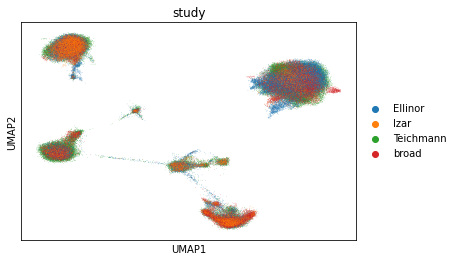

In [5]:
sc.pl.umap(adata, color='study')

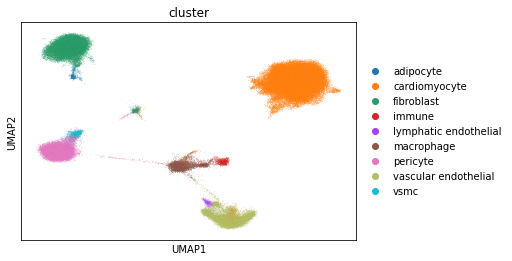

In [6]:
sc.pl.umap(adata, color='cluster')

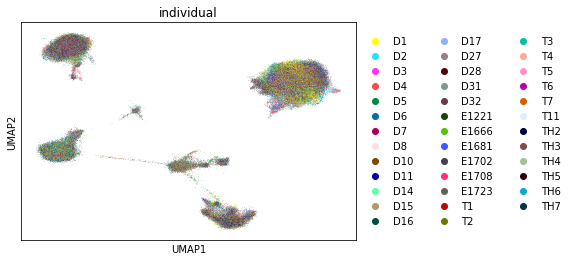

In [7]:
sc.pl.umap(adata, color='individual')

## Additional cell QC

In [8]:
# # entropy calculation

# append_entropy_to_adata(adata)

In [9]:
# adata.obs[['entropy']].to_csv(
#     '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_entropy.csv', 
#     index=True, header=0)

In [10]:
# !head /home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_entropy.csv

In [11]:
# adata.obs['entropy'] = pd.read_csv(
#     '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_entropy.csv',
#     index_col=0, header=None)[1]

In [12]:
# # scrublet, per sample

# def append_scrublet_to_adata(adata, sample_key='sample', layer_key='counts'):
#     """Add scrublet scores to anndata in adata.obs['scrublet']"""
    
# #     adata.obs['scrublet'] = np.nan
#     n = adata.obs[sample_key].nunique()
    
#     for i, s in enumerate(adata.obs[sample_key].unique()):
        
#         ad_subset = adata[adata.obs[sample_key] == s]
#         if ad_subset.obs['scrublet'].apply(pd.isnull).sum() == 0:
#             continue
        
#         print(f'{s}    ({i + 1} / {n})')
        
#         X = ad_subset.layers[layer_key]
#         try:
#             scrub = scrublet.Scrublet(X)
#             doublet_scores, predicted_doublets = scrub.scrub_doublets()
#             adata.obs['scrublet'] = adata.obs['scrublet'].combine_first(
#                 pd.Series(data=doublet_scores, index=ad_subset.obs.index))
#         except ValueError:
#             pass


# # append_scrublet_to_adata(adata)

In [13]:
# adata.obs[['scrublet']].to_csv(
#     '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_scrublet.csv', index=True, header=0)

In [14]:
# adata.obs['scrublet'] = pd.read_csv(
#     '/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_scrublet.csv',
#     index_col=0, header=None)[1]

In [15]:
# adata.obs['n_gene'] = np.array((adata.layers['counts'] > 0).sum(axis=1)).squeeze()

## DE testing

I will simplify the cell types a bit by grouping similar ones...

In [16]:
adata.obs['class'].value_counts()

cardiomyocyte            69794
fibroblast               31080
pericyte                 21590
vascular endothelial     18281
macrophage                5609
smc                       1808
adipocyte                 1130
nk                         655
lymphatic endothelial      530
CD8+ T cell                496
T reg                      110
CD16+ monocyte              61
b                           49
neutrophil                  39
plasma                      38
nkt                         37
erythroid                   37
CD4+ T cell                 10
platelet                     9
pDC                          5
cDC                          5
Name: class, dtype: int64

In [17]:
def simplify_clusters(k):
    """Simplify the cluster naming mainly by grouping immune cells"""
    
    if k == 'smc':
        return 'vsmc'
    elif k in ['nk', 'CD8+ T cell', 'T reg', 'CD16+ monocyte', 'erythroid', 'plasma', 
               'b', 'nkt', 'neutrophil', 'platelet', 'CD4+ T cell', 'cDC', 'pDC']:
        return 'immune'
    else:
        return k

adata.obs['cluster'] = adata.obs['class'].apply(simplify_clusters)

In [18]:
adata.obs['cluster'].value_counts()

cardiomyocyte            69794
fibroblast               31080
pericyte                 21590
vascular endothelial     18281
macrophage                5609
vsmc                      1808
immune                    1551
adipocyte                 1130
lymphatic endothelial      530
Name: cluster, dtype: int64

This is a pseudobulk limma+voom technique.

I will sum over cells that have the same `individual` and `cluster`.

The model will be `~ 0 + disease + study + version10x + sex`

In [19]:
adata.obs['individual_cluster'] = (adata.obs['individual'].astype(str) 
                                   + ':' + adata.obs['cluster'].astype(str))
adata.obs['individual_cluster'] = adata.obs['individual_cluster'].astype('category')

In [20]:
adata.obs['individual_cluster'].value_counts().head()

E1723:cardiomyocyte    8739
TH6:cardiomyocyte      7635
E1681:cardiomyocyte    6166
TH5:cardiomyocyte      5394
TH3:cardiomyocyte      4348
Name: individual_cluster, dtype: int64

Working on cluster group "cardiomyocyte" ========================================

total cells in group = 69794

cells per "disease":
healthy    60667
COVID19     9127
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1723:cardiomyocyte    8739
TH6:cardiomyocyte      7635
E1681:cardiomyocyte    6166
TH5:cardiomyocyte      5394
TH3:cardiomyocyte      4348
E1708:cardiomyocyte    4312
D1:cardiomyocyte       4213
TH7:cardiomyocyte      3884
TH4:cardiomyocyte      3067
E1666:cardiomyocyte    2881
TH2:cardiomyocyte      2748
E1702:cardiomyocyte    2489
T1:cardiomyocyte       2327
E1221:cardiomyocyte    1831
T4:cardiomyocyte       1471
D2:cardiomyocyte       1093
T2:cardiomyocyte        986
T7:cardiomyocyte        884
T5:cardiomyocyte        882
D7:cardiomyocyte        696
D10:cardiomyocyte       553
D4:cardiomyocyte        530
D17:cardiomyocyte       425
T6:cardiomyocyte        405
D8:cardiomyocyte        402
D15:cardiomyocyte       367
D16:cardiomyocyte       315
D14:cardiomyoc

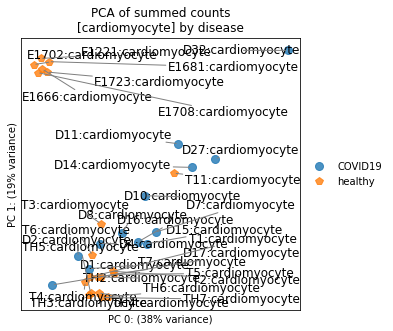

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [19693, 33]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [33, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


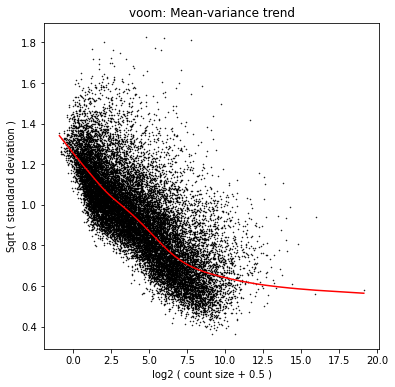

Contrast COVID19 vs. healthy
number of cells in COVID19 = 9127
number of cells in healthy = 60667


Saved grouping ['cardiomyocyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_cardiomyocyte_DE.tsv

Working on cluster group "fibroblast" ========================================

total cells in group = 31080

cells per "disease":
healthy    22097
COVID19     8983
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1666:fibroblast    3528
E1723:fibroblast    2797
E1681:fibroblast    2526
T3:fibroblast       2158
T2:fibroblast       1635
D1:fibroblast       1431
TH3:fibroblast      1429
T5:fibroblast       1286
D27:fibroblast      1166
E1708:fibroblast    1146
D7:fibroblast        963
TH6:fibroblast       917
D2:fibroblast        879
D11:fibroblast       836
D15:fibroblast       756
D28:fibroblast       709
T1:fibroblast        699
T4:fibroblast        631
TH2:fibroblast       497
T7:fibroblast        493
TH5:fibroblast       469
D4:fibroblast        452
D32:fibroblast       430
TH4:fibroblast       399
TH7:fibroblast       389
E1221:fibroblast     389
D16:fibrobl

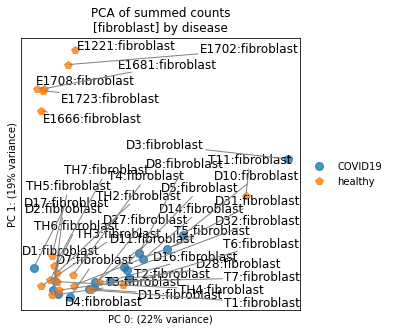

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [14394, 37]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [37, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


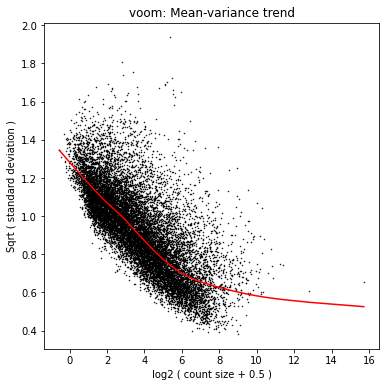

Contrast COVID19 vs. healthy
number of cells in COVID19 = 8983
number of cells in healthy = 22097


Saved grouping ['fibroblast'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_fibroblast_DE.tsv

Working on cluster group "pericyte" ========================================

total cells in group = 21590

cells per "disease":
healthy    18448
COVID19     3142
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH4:pericyte      2854
TH3:pericyte      2518
TH2:pericyte      2029
TH5:pericyte      1966
TH6:pericyte      1879
TH7:pericyte      1742
E1666:pericyte    1195
E1723:pericyte    1021
T2:pericyte        948
D2:pericyte        910
D1:pericyte        879
T3:pericyte        472
E1708:pericyte     375
T1:pericyte        370
T4:pericyte        321
D4:pericyte        299
T5:pericyte        247
D7:pericyte        240
E1681:pericyte     225
D15:pericyte       196
T7:pericyte        118
D27:pericyte       110
D11:pericyte       103
D16:pericyte       102
E1702:pericyte      63
D32:pericyte        62
D28:pericyte        52
D10:pericyte        52
E1221:pericyte      49
D5

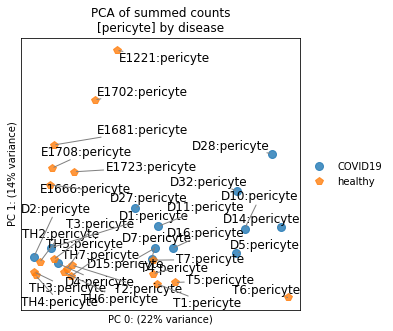

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [11690, 32]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [32, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


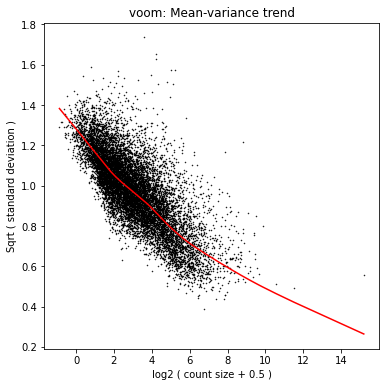

Contrast COVID19 vs. healthy
number of cells in COVID19 = 3142
number of cells in healthy = 18448


Saved grouping ['pericyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_pericyte_DE.tsv

Working on cluster group "vsmc" ========================================

total cells in group = 1808

cells per "disease":
healthy    1261
COVID19     547
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH2:vsmc      230
TH5:vsmc      203
D4:vsmc       174
D2:vsmc       168
TH3:vsmc      129
TH6:vsmc      128
TH7:vsmc      127
TH4:vsmc      119
D1:vsmc        99
E1681:vsmc     71
E1723:vsmc     66
T3:vsmc        60
E1708:vsmc     48
D17:vsmc       37
E1221:vsmc     24
E1666:vsmc     18
T2:vsmc        18
D7:vsmc        15
D15:vsmc       14
D11:vsmc       13
D27:vsmc        9
E1702:vsmc      7
D3:vsmc         5
T5:vsmc         4
T1:vsmc         3
D32:vsmc        3
D16:vsmc        3
T4:vsmc         3
T7:vsmc         2
D10:vsmc        2
D28:vsmc        1
T11:vsmc        1
D5:vsmc         1
D14:vsmc        1
D8:vsmc         1
D31:vsmc        1
Name: individual_cluster, dtype:

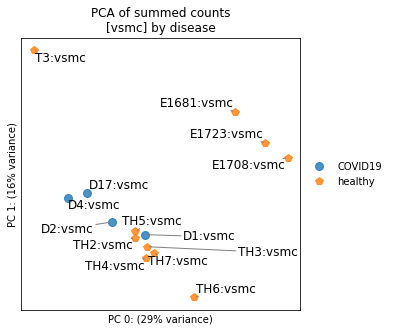

R[write to console]: After trimming genes, summed counts matrix: [9001, 14]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [14, 7]



Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


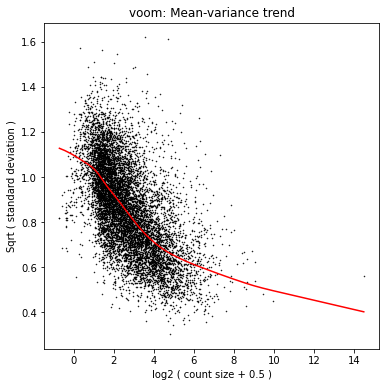

Contrast COVID19 vs. healthy
number of cells in COVID19 = 547
number of cells in healthy = 1261


Saved grouping ['vsmc'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_vsmc_DE.tsv

Working on cluster group "immune" ========================================

total cells in group = 1551

cells per "disease":
healthy    1077
COVID19     474
Name: disease, dtype: int64
 
cells per "individual_cluster":
TH5:immune      272
TH6:immune      133
D15:immune      119
E1723:immune    104
TH7:immune       92
TH2:immune       89
T3:immune        59
TH4:immune       52
T1:immune        51
TH3:immune       49
D32:immune       44
T6:immune        42
D16:immune       42
T2:immune        41
D27:immune       38
D4:immune        36
E1666:immune     36
D2:immune        35
D7:immune        32
D17:immune       31
T7:immune        22
T5:immune        18
D10:immune       17
D11:immune       17
D8:immune        17
D5:immune        16
D28:immune       14
D14:immune       13
T4:immune        11
E1708:immune      3
D1:immune         2
E1681:immune      2
D31:immune        1
T11:immune        1
Name: 

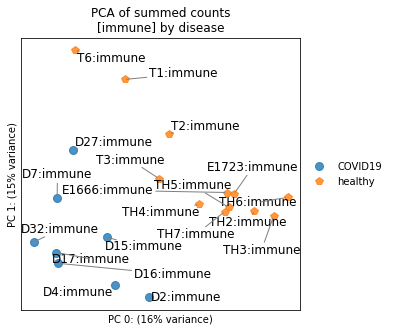

R[write to console]: After trimming genes, summed counts matrix: [4903, 20]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [20, 7]

R[write to console]: Running voomWithQualityWeights



Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...
Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


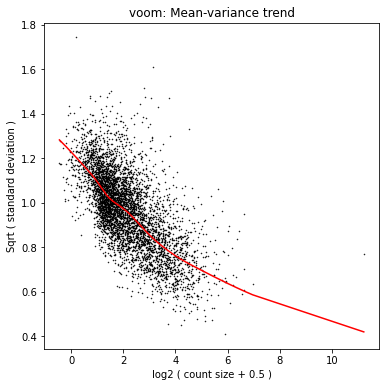

Contrast COVID19 vs. healthy
number of cells in COVID19 = 474
number of cells in healthy = 1077


Saved grouping ['immune'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_immune_DE.tsv

Working on cluster group "macrophage" ========================================

total cells in group = 5609

cells per "disease":
healthy    4249
COVID19    1360
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1723:macrophage    689
T3:macrophage       502
E1666:macrophage    496
T2:macrophage       422
D15:macrophage      283
T5:macrophage       244
D1:macrophage       230
E1681:macrophage    224
E1708:macrophage    223
TH7:macrophage      218
TH2:macrophage      218
D27:macrophage      182
T7:macrophage       179
D2:macrophage       141
TH3:macrophage      133
TH4:macrophage      125
T4:macrophage       122
TH5:macrophage      119
D4:macrophage       116
TH6:macrophage      113
T1:macrophage        98
D7:macrophage        84
D16:macrophage       74
D28:macrophage       71
E1221:macrophage     55
D32:macrophage       52
D17:macrophage       48
T6:macrophage        46
D14:ma

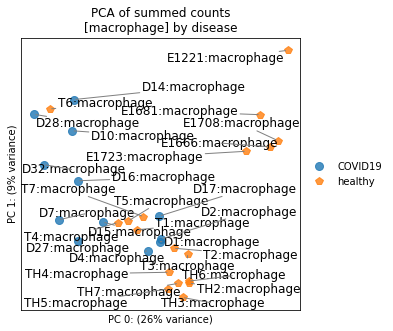

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [8311, 30]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [30, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


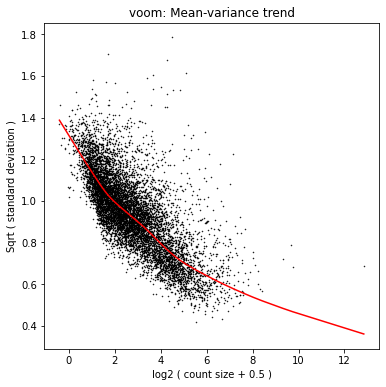

Contrast COVID19 vs. healthy
number of cells in COVID19 = 1360
number of cells in healthy = 4249


Saved grouping ['macrophage'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_macrophage_DE.tsv

Working on cluster group "adipocyte" ========================================

total cells in group = 1130

cells per "disease":
healthy    1041
COVID19      89
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1708:adipocyte    336
E1723:adipocyte    278
TH6:adipocyte       70
E1221:adipocyte     46
T5:adipocyte        42
D17:adipocyte       40
TH3:adipocyte       39
TH7:adipocyte       37
TH2:adipocyte       33
TH5:adipocyte       30
E1666:adipocyte     25
T2:adipocyte        23
TH4:adipocyte       20
E1702:adipocyte     17
T4:adipocyte        15
T3:adipocyte        13
D4:adipocyte        13
T1:adipocyte        11
D28:adipocyte        6
D1:adipocyte         5
D27:adipocyte        5
D10:adipocyte        5
D2:adipocyte         4
E1681:adipocyte      4
D31:adipocyte        2
D15:adipocyte        2
D14:adipocyte        2
D11:adipocyte        2
D32:adipocyte        1
D7:a

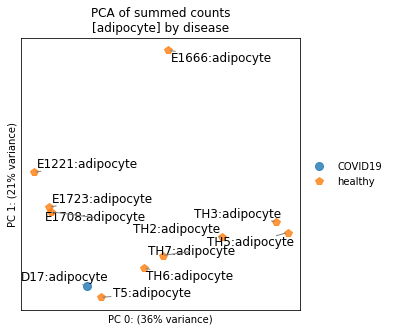

R[write to console]: After trimming genes, summed counts matrix: [8310, 11]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [11, 6]

R[write to console]: Running voomWithQualityWeights



Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...
Coefficients not estimable: studyIzar 
Coefficients not estimable: studyIzar 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyIzar 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


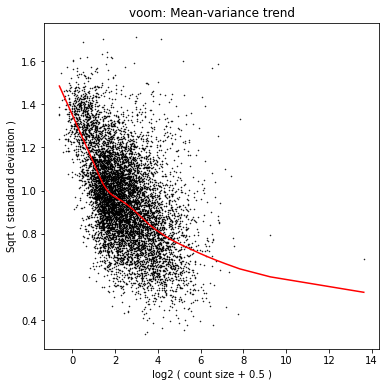

Contrast COVID19 vs. healthy
number of cells in COVID19 = 89
number of cells in healthy = 1041


Saved grouping ['adipocyte'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_adipocyte_DE.tsv

Working on cluster group "vascular endothelial" ========================================

total cells in group = 18281

cells per "disease":
healthy    9667
COVID19    8614
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1666:vascular endothelial    1830
D1:vascular endothelial       1700
D7:vascular endothelial       1131
TH2:vascular endothelial      1011
D2:vascular endothelial       1002
TH3:vascular endothelial       985
D11:vascular endothelial       946
D4:vascular endothelial        920
D15:vascular endothelial       760
T3:vascular endothelial        589
E1723:vascular endothelial     563
TH4:vascular endothelial       507
D16:vascular endothelial       503
D10:vascular endothelial       502
T7:vascular endothelial        497
TH5:vascular endothelial       472
E1681:vascular endothelial     452
T2:vascular endothelial        433
TH6:vascular endothelial       

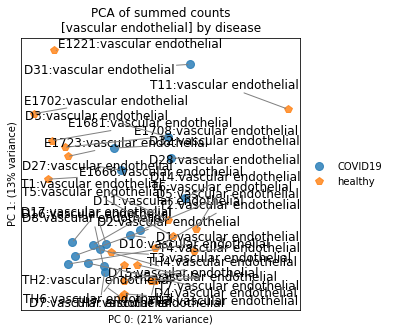

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [11707, 37]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [37, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


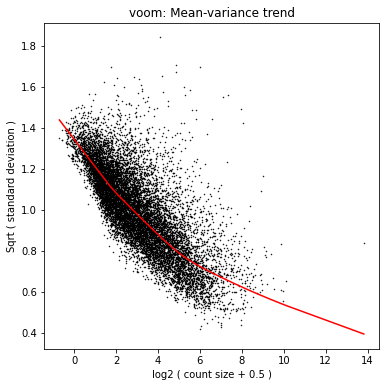

Contrast COVID19 vs. healthy
number of cells in COVID19 = 8614
number of cells in healthy = 9667


Saved grouping ['vascular endothelial'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_vascular endothelial_DE.tsv

Working on cluster group "lymphatic endothelial" ========================================

total cells in group = 530

cells per "disease":
healthy    377
COVID19    153
Name: disease, dtype: int64
 
cells per "individual_cluster":
E1723:lymphatic endothelial    266
D11:lymphatic endothelial       37
E1708:lymphatic endothelial     27
D14:lymphatic endothelial       24
T2:lymphatic endothelial        19
D27:lymphatic endothelial       17
D4:lymphatic endothelial        17
T5:lymphatic endothelial        16
D10:lymphatic endothelial       13
D17:lymphatic endothelial       11
D7:lymphatic endothelial        10
E1681:lymphatic endothelial     10
D16:lymphatic endothelial        9
E1666:lymphatic endothelial      7
E1221:lymphatic endothelial      6
T3:lymphatic endothelial         6
D31:lymphatic endothelial        5
E1702:lymphatic endothelial      4
D5:lymphatic

R[write to console]: After trimming genes, summed counts matrix: [6314, 3]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [3, 5]

R[write to console]: WARNING: experimental design is degenerate, since there are fewer rows than columns+1 in the design matrix.
https://support.bioconductor.org/p/59168/ 
Aborting this test!




Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...
Background RNA probabilities have not been calculated since calculate_background_estimate=False. If you want to try to calculate bkg.prob on your own, it is recommended to try:

df = calculate_bkg_prob(full_adata_with_all_cells_included,
                        testing_key=testing_key,
                        df=df,  # this is from limma_voom_DE()
                        separate_groupings_column=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        separate_groupings_key=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        bcs_included=adata.obs.index)



In [21]:
# use count data
adata.X = adata.layers['counts']

# run method
df = limma_voom_DE(
    adata,
    summation_key='individual_cluster',
    separate_groupings_key='cluster',
    testing_key='disease',
    model='~ 0 + disease + study + version10x + sex',
    model_keys=['disease', 'study', 'version10x', 'sex'],
    one_versus_all_contrasts=False,
    additional_contrasts=['COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy'],
    min_cells_per_test_group=25,
    duplicate_correlation_key=None,
#     separate_groupings='',
    working_directory='/home/jupyter-user/analysis/meta/DE/tmp',
    low_expression_mean_threshold=2.0,
    voom_function='voomWithQualityWeights',
    voom_lowess_span=0.5,
    calculate_background_estimate=False,
#     gene_id_key='gene_id',
    create_PCA_plot=True,
    label_PCA_plot=True,
    verbose=True,
)

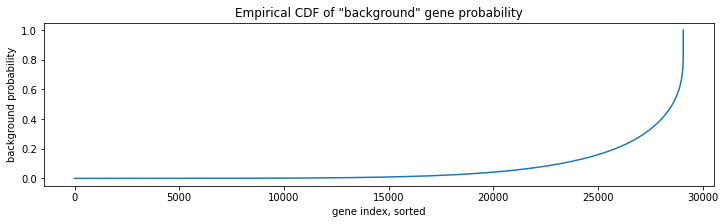

Gene most probable to be background RNA is 
highly_variable                   False
means                           6.30846
dispersions                      5.1729
dispersions_norm                      1
highly_variable_nbatches              0
highly_variable_intersection      False
gene_bkg_prob                         1
Name: MALAT1, dtype: object


Unique conditions under which bkg.prob will be computed:
['cardiomyocyte:::COVID19_healthy' 'fibroblast:::COVID19_healthy'
 'pericyte:::COVID19_healthy' 'vsmc:::COVID19_healthy'
 'immune:::COVID19_healthy' 'macrophage:::COVID19_healthy'
 'adipocyte:::COVID19_healthy' 'vascular endothelial:::COVID19_healthy']
Working on grouping ['cardiomyocyte']
Working on test conditions that include ['COVID19', 'healthy']
69794 cells
Working on grouping ['fibroblast']
Working on test conditions that include ['COVID19', 'healthy']
31080 cells
Working on grouping ['pericyte']
Working on test conditions that include ['COVID19', 'healthy']
21590 cells
Worki

In [22]:
df = calculate_bkg_prob(adata,
                        testing_key='disease',
                        df=df,
                        separate_groupings_column='cluster',
                        separate_groupings_key='cluster',
                        bcs_included=adata.obs.index)

In [23]:
df

gene               cluster test.group comparison     logFC  \
0         PLCG2         cardiomyocyte    COVID19    healthy  5.152630   
1          CTSL         cardiomyocyte    COVID19    healthy -6.140759   
2        EXOSC8         cardiomyocyte    COVID19    healthy -2.692548   
3       NDUFAF4         cardiomyocyte    COVID19    healthy -3.130870   
4      TMEM179B         cardiomyocyte    COVID19    healthy -2.875175   
...         ...                   ...        ...        ...       ...   
88004     TTYH2  vascular endothelial    COVID19    healthy -0.001088   
88005     SRP19  vascular endothelial    COVID19    healthy  0.000188   
88006    MRPS15  vascular endothelial    COVID19    healthy  0.000215   
88007     SNX19  vascular endothelial    COVID19    healthy -0.000082   
88008   PPP4R3B  vascular endothelial    COVID19    healthy -0.000018   

        AveExpr          t       P.Value     adj.P.Val          B  ...  \
0      4.065135  13.879645  4.445325e-15  8.754178e-11  24.298142  ...   
1      2.184375 -11.436916  7.860921e-13  7.380219e-09  18.452254  ...   
2      2.781197 -11.227102  1.242073e-12  7.380219e-09  18.670050  ...   
3      3.277407 -11.145156  1.499054e-12  7.380219e-09  18.440547  ...   
4      2.468725 -10.786201  3.450477e-12  1.321181e-08  17.583422  ...   
...         ...        ...           ...           ...        ...  ...   
88004  2.326908  -0.001389  9.988991e-01  9.992406e-01  -6.091598  ...   
88005  3.817882   0.000470  9.996273e-01  9.998490e-01  -6.540551  ...   
88006  2.335612   0.000319  9.997473e-01  9.998490e-01  -6.109346  ...   
88007  5.341663  -0.000298  9.997636e-01  9.998490e-01  -6.700246  ...   
88008  6.117662  -0.000084  9.999338e-01  9.999338e-01  -6.847392  ...   

       comparison.frac.expr>0  test.group.frac.expr>1  comparison.frac.expr>1  \
0                    0.026406                0.324532                0.001319   
1                    0.118170                0.001643                0.013813   
2                    0.114774                0.001534                0.013516   
3                    0.151450                0.003177                0.023489   
4                    0.096939                0.001424                0.009412   
...                       ...                     ...                     ...   
88004                0.009724                0.000464                0.000310   
88005                0.021930                0.003715                0.001759   
88006                0.010241                0.000000                0.000103   
88007                0.057722                0.010216                0.004034   
88008                0.093411                0.028442                0.010965   

       bkg.prob  PPV.expr>0  PPV.expr>1  frac.cells.in.group.expr>0  \
0      0.191386    0.388479    0.417893                    0.098246   
1      0.062684    0.607905    0.560708                    0.104207   
2      0.029085    0.699042    0.828584                    0.103103   
3      0.016481    0.830738    0.932852                    0.136416   
4      0.041773    0.602303    0.701800                    0.086970   
...         ...         ...         ...                         ...   
88004  0.073010    0.148432    0.061224                    0.009135   
88005  0.093506    0.301356    0.202547                    0.032055   
88006  0.037206    0.216384    0.036106                    0.008369   
88007  0.120889    0.378591    0.318368                    0.068213   
88008  0.152873    0.429607    0.395557                    0.121219   

       frac.cells.out.group.expr>0  frac.cells.in.group.expr>1  \
0                         0.154643                    0.043585   
1                         0.067203                    0.012222   
2                         0.044379                    0.011949   
3                         0.027785                    0.020833   
4                         0.057416                    0.008367   
...                    

In [24]:
df.columns

Index(['gene', 'cluster', 'test.group', 'comparison', 'logFC', 'AveExpr', 't',
       'P.Value', 'adj.P.Val', 'B', 'test.group.cell.mean.counts',
       'comparison.cell.mean.counts', 'test.group.frac.expr>0',
       'comparison.frac.expr>0', 'test.group.frac.expr>1',
       'comparison.frac.expr>1', 'bkg.prob', 'PPV.expr>0', 'PPV.expr>1',
       'frac.cells.in.group.expr>0', 'frac.cells.out.group.expr>0',
       'frac.cells.in.group.expr>1', 'frac.cells.out.group.expr>1'],
      dtype='object')

In [25]:
df.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC.csv')

In [26]:
df[['gene', 'cluster', 'test.group', 'comparison', 'logFC', 'AveExpr', 't',
       'P.Value', 'adj.P.Val', 'B', 'test.group.cell.mean.counts',
       'comparison.cell.mean.counts', 'test.group.frac.expr>0',
       'comparison.frac.expr>0', 'test.group.frac.expr>1',
       'comparison.frac.expr>1', 'bkg.prob']][df['adj.P.Val'] <= 0.05]\
.sort_values(by=['cluster', 'logFC'], ascending=[True, False])\
.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC_summary.csv')

Working on the entire dataset at once ========================================

total cells in group = 151373

cells per "disease":
healthy    118884
COVID19     32489
Name: disease, dtype: int64
 
cells per "individual":
E1723    14523
TH6      11311
E1666    10016
E1681     9680
TH3       9631
TH5       8925
D1        8561
TH4       7143
TH7       6902
TH2       6857
E1708     6787
T2        4525
D2        4232
T3        4006
T1        3805
D7        3172
E1702     3088
T5        2969
T4        2870
D4        2557
D15       2498
E1221     2452
T7        2199
D11       2105
D27       1781
D16       1389
D10       1287
T6         987
D28        961
D17        923
D8         908
D32        708
D14        563
D5         497
D31        227
T11        208
D3         112
D6           8
Name: individual, dtype: int64
 
Summing adata.X per "individual": 38 unique groups
......................................
The following groupings yield fewer than 25 cells:
['D6']
Done summing counts.



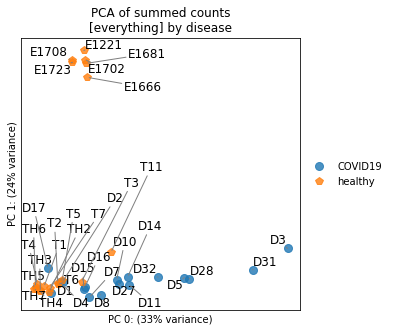

Contrasts: 
COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy

Running limma-voom in R...


R[write to console]: After trimming genes, summed counts matrix: [21003, 37]

R[write to console]: 
Level of disease: COVID19
Level of disease: healthy

R[write to console]: 
Level of study: broad
Level of study: Ellinor
Level of study: Izar
Level of study: Teichmann

R[write to console]: 
Level of version10x: V2
Level of version10x: V3

R[write to console]: 
Level of sex: female
Level of sex: male

R[write to console]: design <- model.matrix(~ 0 + disease + study + version10x + sex)

R[write to console]: Dimension of design matrix: [37, 7]

R[write to console]: Running voomWithQualityWeights



Coefficients not estimable: studyTeichmann 
Coefficients not estimable: studyTeichmann 


R[write to console]: Writing voom plot information to /home/jupyter-user/analysis/meta/DE/tmp/R_voom_plot.tsv

R[write to console]: Running lmFit



Coefficients not estimable: studyTeichmann 


R[write to console]: Fitting contrasts

R[write to console]: Writing contrast matrix to /home/jupyter-user/analysis/meta/DE/tmp/R_limma_contrasts.tsv

R[write to console]: Writing topTable to /home/jupyter-user/analysis/meta/DE/tmp/COVID19.vs.healthy.tsv



Contrast matrix used by Limma:


Voom plot:


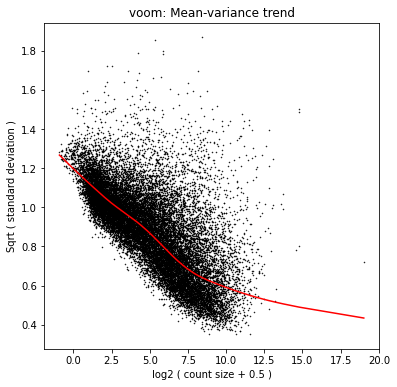

Contrast COVID19 vs. healthy
number of cells in COVID19 = 32489
number of cells in healthy = 118884


Saved grouping ['everything'] data to /home/jupyter-user/analysis/meta/DE/tmp/grouping_everything_DE.tsv

Background RNA probabilities have not been calculated since calculate_background_estimate=False. If you want to try to calculate bkg.prob on your own, it is recommended to try:

df = calculate_bkg_prob(full_adata_with_all_cells_included,
                        testing_key=testing_key,
                        df=df,  # this is from limma_voom_DE()
                        separate_groupings_column=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        separate_groupings_key=separate_groupings_key,  # remove this line if no separate_groupings_key used
                        bcs_included=adata.obs.index)



In [27]:
# use count data
adata.X = adata.layers['counts']

# run method
df_overall = limma_voom_DE(
    adata,
    summation_key='individual',
    separate_groupings_key=None,
    testing_key='disease',
    model='~ 0 + disease + study + version10x + sex',
    model_keys=['disease', 'study', 'version10x', 'sex'],
    one_versus_all_contrasts=False,
    additional_contrasts=['COVID19.vs.healthy = diseaseCOVID19 - diseasehealthy'],
    min_cells_per_test_group=25,
    duplicate_correlation_key=None,
#     separate_groupings='',
    working_directory='/home/jupyter-user/analysis/meta/DE/tmp',
    low_expression_mean_threshold=2.0,
    voom_function='voomWithQualityWeights',
    voom_lowess_span=0.5,
    calculate_background_estimate=False,
#     gene_id_key='gene_id',
    create_PCA_plot=True,
    label_PCA_plot=True,
    verbose=True,
)

In [28]:
df_overall[((df_overall['test.group.cell.mean.counts'] > 0.05)
             | (df_overall['comparison.cell.mean.counts'] > 0.05))
           & (df_overall['adj.P.Val'] < 0.01)]\
.sort_values(by='logFC', ascending=False).head(20)

gene clusters.included test.group comparison     logFC   AveExpr  \
367         RPS3        everything    COVID19    healthy  6.811560  2.221929   
5171         HBB        everything    COVID19    healthy  6.479975 -0.836422   
153       RPL13A        everything    COVID19    healthy  5.502350  2.940028   
3          VEGFC        everything    COVID19    healthy  5.323363  3.800513   
891       RPL37A        everything    COVID19    healthy  5.311852  2.700518   
0          PLCG2        everything    COVID19    healthy  5.026446  5.032108   
500        RPS19        everything    COVID19    healthy  4.849093  2.890659   
1503       RPL28        everything    COVID19    healthy  4.687909  2.173765   
445         EEF2        everything    COVID19    healthy  4.623476  3.284555   
1104  AC007952.4        everything    COVID19    healthy  4.522990 -0.026980   
563       IFITM2        everything    COVID19    healthy  4.351383  3.129823   
1768       RPL15        everything    COVID19    healthy  4.296585  2.660943   
1473        EGR1        everything    COVID19    healthy  4.296269  3.222837   
1266        GPX3        everything    COVID19    healthy  4.222871  4.930041   
4486        PTX3        everything    COVID19    healthy  4.220753  1.030305   
1121       DEPP1        everything    COVID19    healthy  4.130131  2.121642   
847       IGFBP3        everything    COVID19    healthy  4.124289  3.152347   
2326       THBS1        everything    COVID19    healthy  4.119204  4.825609   
922         RPL3        everything    COVID19    healthy  4.112672  2.351114   
412       PCAT19        everything    COVID19    healthy  4.105180  2.566568   

              t       P.Value     adj.P.Val          B  \
367    8.074969  1.831859e-09  1.045504e-07  11.634477   
5171   3.866513  4.676888e-04  1.899240e-03  -0.121529   
153    9.086645  1.001484e-10  1.365855e-08  14.472705   
3     12.756653  7.780485e-15  3.950935e-11  23.691404   
891    6.850423  6.439084e-08  1.516144e-06   8.183819   
0     17.498398  3.623335e-19  7.610091e-15  33.420005   
500    7.639291  6.201306e-09  2.598959e-07  10.454203   
1503   6.058996  6.838004e-07  9.541915e-06   5.889422   
445    7.805837  3.718467e-09  1.751098e-07  10.948541   
1104   6.459624  1.785606e-07  3.393943e-06   7.214964   
563    7.476453  9.977386e-09  3.715515e-07   9.955973   
1768   5.775796  1.597134e-06  1.896246e-05   5.059703   
1473   6.083003  6.361861e-07  9.065004e-06   5.913064   
1266   6.300189  3.350980e-07  5.554903e-06   6.401527   
4486   4.151247  2.056045e-04  9.624050e-04   0.519112   
1121   6.484928  1.896524e-07  3.550150e-06   7.087072   
847    6.903166  5.355814e-08  1.326511e-06   8.319969   
2326   5.334410  6.117420e-06  5.521452e-05   3.524808   
922    6.749151  7.913891e-08  1.800818e-06   7.986768   
412    7.842022  2.972368e-09  1.511589e-07  11.169209   

      test.group.cell.mean.counts  comparison.cell.mean.counts  \
367                      0.083381                     0.018354   
5171                     0.123303                     0.001203   
153                      0.095784                     0.034690   
3                        0.295429                     0.016386   
891                      0.108373                     0.022442   
0                        1.085605                     0.032158   
500                      0.105018                     0.023898   
1503                     0.069346                     0.017286   
445                      0.101602                     0.031603   
1104                     0.053002                     0.001876   
563                      0.097600                     0.029525   
1768                     0.067837                     0.029567   
1473                     0.129612                     0.018943   
1266                     0.303404                     0.089197   
4486                     0.065991                     0.007427   
1121                     0.151929                     0.

In [29]:
sc.pp.normalize_total(adata)

... storing 'cluster' as categorical
... storing 'cluster_disease' as categorical


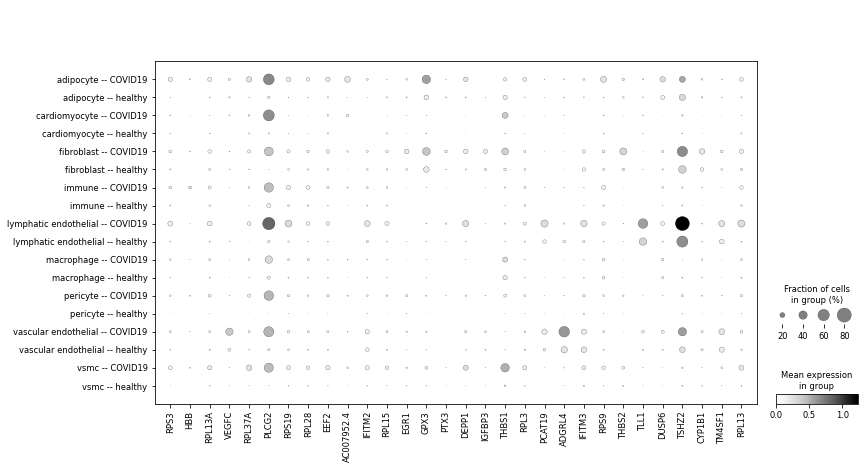

In [30]:
genes = df_overall[((df_overall['test.group.cell.mean.counts'] > 0.05)
                     | (df_overall['comparison.cell.mean.counts'] > 0.05))
                   & (df_overall['adj.P.Val'] < 0.01)]\
        .sort_values(by='logFC', ascending=False).head(30)['gene'].tolist()

adata.obs['cluster_disease'] = (adata.obs['cluster'].astype(str) 
                                + ' -- ' + adata.obs['disease'].astype(str))

sc.pl.dotplot(adata,
              groupby='cluster_disease',
              var_names=genes,
#               standard_scale='var',
              log=True,
              color_map='Greys',
              smallest_dot=15)

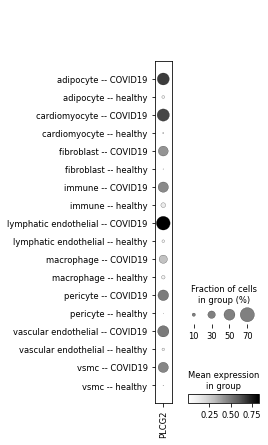

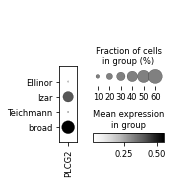

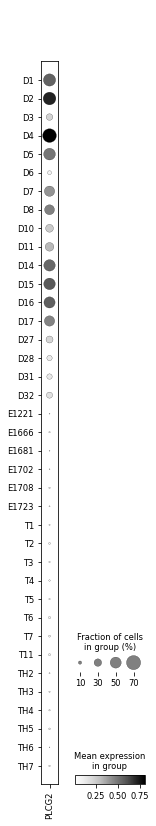

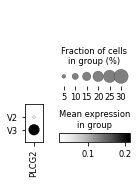

In [31]:
for group in ['cluster_disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=['PLCG2'],
    #               standard_scale='var',
                  log=True,
                  color_map='Greys',
                  smallest_dot=15)

PLCG2 is totally out of control in COVID19.

In [32]:
adata.var_names[adata.var_names.str.startswith('HSP')]

Index(['HSP90AA1', 'HSP90AB1', 'HSP90B1', 'HSPA12A', 'HSPA12B', 'HSPA13',
       'HSPA14_ENSG00000187522', 'HSPA1A', 'HSPA1B', 'HSPA1L', 'HSPA2',
       'HSPA4', 'HSPA4L', 'HSPA5', 'HSPA6', 'HSPA8', 'HSPA9', 'HSPB1',
       'HSPB11', 'HSPB2', 'HSPB2-C11orf52', 'HSPB3', 'HSPB6', 'HSPB7', 'HSPB8',
       'HSPB9', 'HSPBAP1', 'HSPBP1', 'HSPD1', 'HSPE1', 'HSPE1-MOB4', 'HSPG2',
       'HSPH1'],
      dtype='object', name='featurekey')

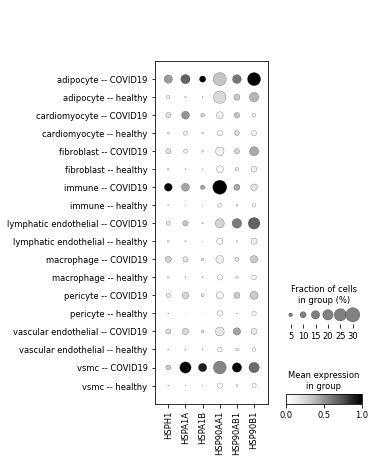

In [33]:
# the heat shock proteins seem to appear

genes = ['HSPH1', 'HSPA1A', 'HSPA1B', 'HSP90AA1', 'HSP90AB1', 'HSP90B1']

sc.pl.dotplot(adata,
              groupby='cluster_disease',
              var_names=genes,
              standard_scale='var',
#               log=True,
              color_map='Greys',
              smallest_dot=15)

## Exploration

In [ ]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC.csv')

## (Equivalent of Extended Data Figure 11g, 11h, 11i ... but with extra cell QC)

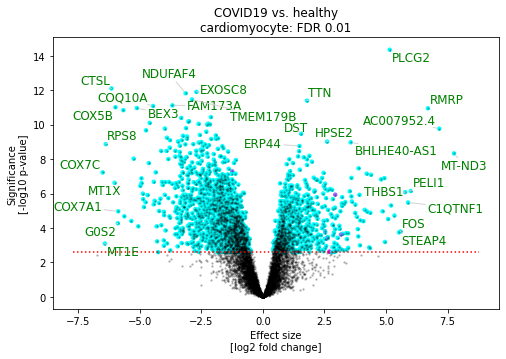

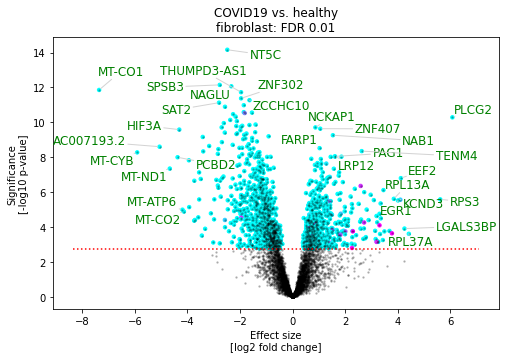

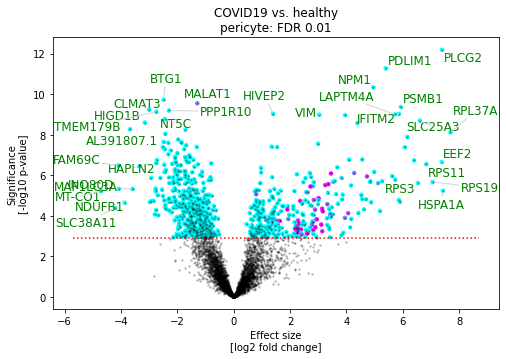

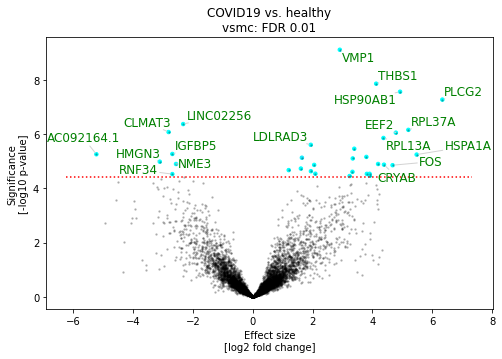

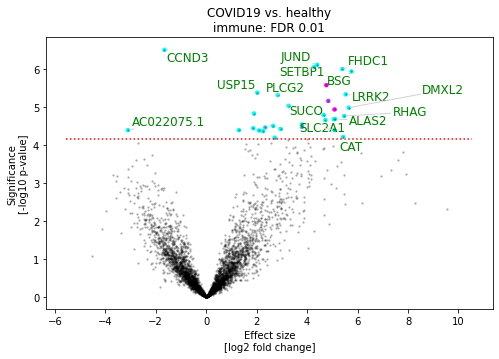

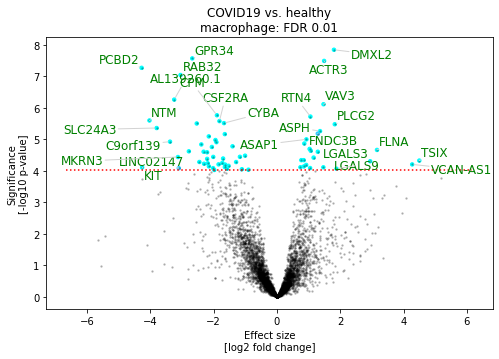

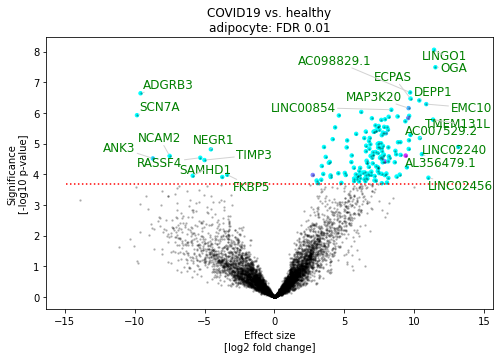

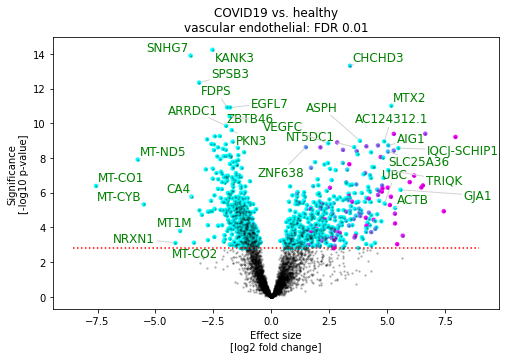

In [34]:
for k in df['cluster'].unique():
    
    volcano_plot(df[((df['test.group.cell.mean.counts'] > 0.05)
                      | (df['comparison.cell.mean.counts'] > 0.05))], 
                 FDR=0.01, 
                 cluster_column_label='cluster',
                 cluster_value=k,
                 test_group_value='COVID19',
                 comparison_value='healthy',
                 num=8,
                 title=f'COVID19 vs. healthy\n{k}: FDR 0.01',
                 show=False
                 )
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_extraQC_{k}_volcano.pdf')
    plt.show()

In [ ]:
all_volcano_plots(df[((df['test.group.cell.mean.counts'] > 0.05)
                      | (df['comparison.cell.mean.counts'] > 0.05))], 
                  FDR=0.01, 
                  cluster_column_name='cluster',
                  num=8)

## GSEA

In [3]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC.csv')

In [ ]:
gsea_df = gsea_from_DE(
    df,
    gmt_files=['/home/jupyter-user/analysis/meta/c5.go.bp.v7.2.symbols.gmt',
               '/home/jupyter-user/analysis/meta/c5.go.mf.v7.2.symbols.gmt'],
#                '/home/jupyter-user/analysis/meta/c7.all.v7.2.symbols.gmt',
#                '/home/jupyter-user/analysis/meta/c8.all.v7.2.symbols.gmt'],
    bkg_prob_cutoff=0.4,
    separate_groupings_column='cluster',
    gene_key='gene',
    ranking_key='t',
)

In [5]:
# gsea_df.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_GSEA_20210208_extraQC.csv')

In [3]:
gsea_df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_GSEA_20210208_extraQC.csv')

In [ ]:
gsea_df.head()

In [5]:
gsea_df[(gsea_df['cluster'] == 'cardiomyocyte') 
        & (gsea_df['padj'] < 0.01) 
        & (gsea_df['NES'] < 0)].sort_values(by='NES', ascending=True).head()

Unnamed: 0        cluster test.group comparison  \
7338        7338  cardiomyocyte    COVID19    healthy   
7337        7337  cardiomyocyte    COVID19    healthy   
7336        7336  cardiomyocyte    COVID19    healthy   
7335        7335  cardiomyocyte    COVID19    healthy   
7334        7334  cardiomyocyte    COVID19    healthy   

                                         pathway      pval     padj        ES  \
7338            GO_MITOCHONDRIAL_GENE_EXPRESSION  0.000001  0.00027 -0.652708   
7337                GO_MITOCHONDRIAL_TRANSLATION  0.000002  0.00027 -0.669416   
7336  GO_MITOCHONDRIAL_TRANSLATIONAL_TERMINATION  0.000002  0.00027 -0.709238   
7335                GO_TRANSLATIONAL_TERMINATION  0.000002  0.00027 -0.665253   
7334                 GO_TRANSLATIONAL_ELONGATION  0.000002  0.00027 -0.612155   

           NES  nMoreExtreme  size  \
7338 -3.166818           0.0   154   
7337 -3.155928           0.0   127   
7336 -3.127362           0.0    85   
7335 -3.018263           0.0   100   
7334 -2.882487           0.0   126   

                                            leadingEdge  
7338  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|TACO...  
7337  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|TACO...  
7336  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...  
7335  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...  
7334  MRPS26|MRPS34|MRPL57|MRPS16|MRPL34|MRPS12|MRPL...

In [6]:
gsea_df[(gsea_df['cluster'] == 'cardiomyocyte') 
        & (gsea_df['padj'] < 0.01) 
        & (gsea_df['NES'] > 0)].sort_values(by='NES', ascending=False).head()

Unnamed: 0        cluster test.group comparison  \
0           0  cardiomyocyte    COVID19    healthy   
1           1  cardiomyocyte    COVID19    healthy   
2           2  cardiomyocyte    COVID19    healthy   
3           3  cardiomyocyte    COVID19    healthy   
4           4  cardiomyocyte    COVID19    healthy   

                                             pathway      pval      padj  \
0  GO_REGULATION_OF_B_CELL_RECEPTOR_SIGNALING_PAT...  0.000007  0.000439   
1                          GO_CELLULAR_EXTRAVASATION  0.000003  0.000318   
2  GO_CELL_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHE...  0.000003  0.000318   
3               GO_B_CELL_RECEPTOR_SIGNALING_PATHWAY  0.000003  0.000318   
4                             GO_LEUKOCYTE_MIGRATION  0.000004  0.000318   

         ES       NES  nMoreExtreme  size  \
0  0.667580  2.327015           2.0    23   
1  0.536307  2.318657           0.0    54   
2  0.425428  2.303514           0.0   185   
3  0.534787  2.292972           0.0    52   
4  0.387970  2.260656           0.0   330   

                                         leadingEdge  
0  PAX5|SLC39A10|LYN|PRKCH|CD22|RUNX1|ELF1|CD300A...  
1  IL1R1|SIRPA|AZU1|PIK3CD|GCNT1|FER|BCR|PLVAP|PE...  
2  IL1RAP|TENM4|GPC4|TGFB2|EFNA5|MAG|PTPRT|ITGA5|...  
3  PLCG2|PAX5|KLHL6|SLC39A10|LYN|PIK3CD|PRKCH|CD7...  
4  THBS1|IL1R1|OXSR1|MSN|TGFB2|ADAM10|VEGFC|MAG|H...

In [9]:
gsea_df[(gsea_df['pathway'] == 'GO_VIRAL_GENE_EXPRESSION')
        & (gsea_df['padj'] <= 0.01)].sort_values(by='NES', ascending=False)

Unnamed: 0               cluster test.group comparison  \
35985           6                immune    COVID19    healthy   
62551           4             adipocyte    COVID19    healthy   
27057          15                  vsmc    COVID19    healthy   
18049          33              pericyte    COVID19    healthy   
44648          55  vascular endothelial    COVID19    healthy   

                        pathway      pval      padj        ES       NES  \
35985  GO_VIRAL_GENE_EXPRESSION  0.000002  0.000340  0.640856  2.847057   
62551  GO_VIRAL_GENE_EXPRESSION  0.000002  0.001080  0.476725  2.263784   
27057  GO_VIRAL_GENE_EXPRESSION  0.000002  0.000265  0.467205  2.181839   
18049  GO_VIRAL_GENE_EXPRESSION  0.000005  0.000711  0.416497  2.132503   
44648  GO_VIRAL_GENE_EXPRESSION  0.000007  0.001516  0.379241  1.894239   

       nMoreExtreme  size                                        leadingEdge  
35985           0.0   133  RPS15|RPL27|RPL37A|RPL28|RPS9|RPL27A|RPL7A|RPS...  
62551           0.0   147  RPL28|RPS19|RPS24|RPL37A|RPL13A|RPS9|RPS2|RPS1...  
27057           0.0   160  RPL37A|RPS19|RPS15A|IFITM3|RPL13A|RPL13|RPS9|R...  
18049           0.0   178  RPL37A|RPS19|RPS15A|RPL13|RPS9|RPL13A|RPL18A|R...  
44648           1.0   178  RPL37A|NUCKS1|RPL18|RPS9|RPS24|RPL37|RPL13A|RP...

In [15]:
pd.Series('|'.join(gsea_df[(gsea_df['pathway'] == 'GO_VIRAL_GENE_EXPRESSION')
        & (gsea_df['padj'] <= 0.01)].sort_values(by='NES', ascending=False)['leadingEdge']\
    .values.tolist()).split('|')).value_counts().head(50)

RPL23A    5
RPL41     5
RPS24     5
RPL28     5
RPL14     5
RPL37     5
RPL3      5
RPS6      5
RPL11     5
RPL7A     5
RPL34     5
RPS15     5
RPL13A    5
RPS16     5
RPS19     5
RPL8      5
RPL27A    5
RPL18     5
RPS4X     5
RPL15     5
RPLP1     5
RPL37A    5
CHD1      5
RPL7      5
RPS9      5
RPS3      5
RPL19     5
RPS25     5
RPL13     5
RPS5      4
RPS12     4
RPL10A    4
RPS23     4
EIF3A     4
MID2      4
NUCKS1    4
EIF3L     4
RPS15A    4
RPS18     4
RPL23     4
RPL27     4
RPS11     4
RPL38     4
RPL35     4
RPL21     4
IFITM3    4
RPSA      4
RPL29     4
RPS20     4
RPLP2     3
dtype: int64

Maybe interesting, maybe not... this could be ribosomal transcripts from cytoplasmic contamination?

In [ ]:
for cluster in gsea_df['cluster'].unique():
    
    print(cluster, '===============================')

#     plot_pathway_heatmap(
#         gsea_df[gsea_df['cluster'] == cluster],
#         fdr=0.01,
#         max_per_group=30,
#     #     sort_by=['NES'],
#     #     test_group_order: Union[List[str], NoneType] = None,
#     #     test_group_mapping: Union[Dict[str, str], NoneType] = None,
#         p_value_style='both',
#         size_legend_values=[1, 2, 4, 6],
#         colorbar_aspect=10,
#         fontsize=10,
#         vmin=-2.5,
#         vmax=2.5,
#         show=False,
#     )
#     plt.show()
    
    plot_pathway_bars(
        gsea_df[gsea_df['cluster'] == cluster], 
        fdr=0.01,
        n_pathways=15,
        enriched_only=False,
        labels_on_top=True,
        figsize=(12, 4),
        fontsize=16,
        asterisk_size=8,
#         pathway_name_fcn=lambda s: s,
        show=False,
    )
    
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{cluster}_gsea_bar.pdf',
                      bbox_inches='tight')
    
    plt.show()

## Comparison with DE results obtained by Graham Heimberg using a different method

In [92]:
PSEUDOBULK = True

In [93]:
pd.options.display.max_columns = None

In [86]:
df = pd.read_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC.csv')

In [87]:
df['cluster'].unique()

array(['cardiomyocyte', 'fibroblast', 'pericyte', 'vsmc', 'immune',
       'macrophage', 'adipocyte', 'vascular endothelial'], dtype=object)

In [94]:
import glob

if PSEUDOBULK:
    graham_files = glob.glob('/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/*.csv')
else:
    graham_files = glob.glob('/home/jupyter-user/analysis/meta/DE/graham_cell/*.csv')
    
    
graham_files

['/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/smc.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/nk.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/fibroblast.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/macrophage.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/pericyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/lymphatic endothelial.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/cardiomyocyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/adipocyte.csv',
 '/home/jupyter-user/analysis/meta/DE/pseudobulk_fixed/vascular endothelial.csv']

In [95]:
dfs = []

for file in graham_files:
    df_tmp = pd.read_csv(file)
    cluster = file.split('/')[-1].split('.')[0]
    
    if cluster == 'lymphEC':
        continue
    
    df_tmp.insert(1, column='cluster', value=cluster
                  .replace('nk', 'immune')
                  .replace('smc', 'vsmc'))
    dfs.append(df_tmp)
    
df_graham = pd.concat(dfs, axis=0)
df_graham = df_graham.rename(columns={'Unnamed: 0': 'gene'})
df_graham = df_graham.rename(columns={'featurekey': 'gene'})

In [96]:
df_graham

gene               cluster  constant_log2fc  COVID19_log2fc  \
0           A1BG                  vsmc        -0.000964       -0.002445   
1       A1BG-AS1                  vsmc         0.116152       -0.459950   
2            A2M                  vsmc         0.165613       -0.379311   
3      A2ML1-AS1                  vsmc         0.133535       -0.448457   
4         A4GALT                  vsmc         0.107464       -0.353786   
...          ...                   ...              ...             ...   
18884       ZXDC  vascular endothelial         0.063210       -0.101335   
18885     ZYG11A  vascular endothelial        -0.095047        0.209318   
18886     ZYG11B  vascular endothelial         0.026989       -0.076224   
18887        ZYX  vascular endothelial        -0.030142       -0.057563   
18888      ZZEF1  vascular endothelial         0.020256        0.061590   

       Ellinor_log2fc  Izar_log2fc  Techmann_log2fc  Broad_log2fc  \
0           -0.039830     0.280061         0.041311     -0.282506   
1            0.242747    -0.279702         0.333354     -0.180248   
2            0.653355    -0.398975        -0.108431      0.019664   
3            0.359331    -0.240590         0.222661     -0.207867   
4            0.297865    -0.200658         0.163384     -0.153128   
...               ...          ...              ...           ...   
18884        0.265676    -0.073136        -0.101131     -0.028199   
18885       -0.200583    -0.391568        -0.103783      0.600886   
18886        0.059745     0.033808         0.043467     -0.110032   
18887       -0.238159     0.020072         0.265580     -0.077635   
18888        0.110955     0.258140        -0.152289     -0.196550   

       constant_pval  COVID19_pval  Ellinor_pval  Izar_pval  Techmann_pval  \
0           0.994383      0.988016      0.894015   0.303158       0.852928   
1           0.341031      0.002764      0.361971   0.246496       0.097493   
2           0.188562      0.014046      0.020646   0.110336       0.593123   
3           0.282768      0.003950      0.187500   0.325850       0.271355   
4           0.409399      0.026660      0.296498   0.434583       0.440679   
...              ...           ...           ...        ...            ...   
18884       0.638343      0.519830      0.375101   0.782450       0.636153   
18885       0.443306      0.152569      0.465856   0.113477       0.597736   
18886       0.841685      0.629916      0.842080   0.898981       0.839617   
18887       0.820601      0.711260      0.421208   0.938919       0.213069   
18888       0.879330      0.693249      0.708075   0.329188       0.474064   

       Broad_pval    sig  adjusted  neg_log_pval_adjusted  
0        0.285198  False       1.0          -0.000000e+00  
1        0.439561  False       1.0           3.809093e-15  
2        0.934260  False       1.0          -0.000000e+00  
3        0.381483  False       1.0          -0.000000e+00  
4        0.538623  False       1.0          -0.000000e+00  
...           ...    ...       ...                    ...  
18884    0.908315  False       1.0          -0.000000e+00  
18885    0.010505  False       1.0          -0.000000e+00  
18886    0.655442  False       1.0          -0.000000e+00  
18887    0.748762  False       1.0          -0.000000e+00  
18888    0.420901  False       1.0          -0.000000e+00  

[133161 rows x 17 columns]

In [97]:
df_graham[df_graham['gene'] == 'PLCG2']

gene                cluster  constant_log2fc  COVID19_log2fc  \
7578   PLCG2                   vsmc        -0.162920        0.622998   
3614   PLCG2                 immune        -0.238645        0.674918   
15087  PLCG2             fibroblast        -0.209595        0.735462   
9742   PLCG2             macrophage        -0.189845        0.585630   
13622  PLCG2               pericyte        -0.204184        0.741024   
4085   PLCG2  lymphatic endothelial        -0.191652        0.817092   
18192  PLCG2          cardiomyocyte        -0.186831        0.776791   
6006   PLCG2              adipocyte        -0.163204        0.474113   
13059  PLCG2   vascular endothelial        -0.213692        0.725431   

       Ellinor_log2fc  Izar_log2fc  Techmann_log2fc  Broad_log2fc  \
7578        -0.339866     0.165220        -0.446052      0.457777   
3614        -0.483360     0.093517        -0.430203      0.581401   
15087       -0.470191     0.334259        -0.474865      0.401203   
9742        -0.550333     0.372210        -0.225141      0.213420   
13622       -0.487780     0.160279        -0.457428      0.580745   
4085        -0.489940     0.611224        -0.518804      0.205868   
18192       -0.495588     0.455931        -0.468034      0.320860   
6006        -0.451988     0.053052        -0.185329      0.421061   
13059       -0.435732     0.083093        -0.503391      0.642338   

       constant_pval  COVID19_pval  Ellinor_pval  Izar_pval  Techmann_pval  \
7578        0.117666  9.328148e-06      0.134461   0.415232       0.010591   
3614        0.062516  6.306927e-06      0.114395   0.628720       0.016841   
15087       0.016514  3.689946e-09      0.015457   0.049610       0.000954   
9742        0.089827  5.228894e-05      0.027600   0.091492       0.207000   
13622       0.015888  2.188068e-09      0.009725   0.324899       0.000999   
4085        0.012792  7.135744e-11      0.003994   0.000271       0.000104   
18192       0.026069  1.094099e-09      0.008432   0.007529       0.000762   
6006        0.171255  1.432667e-03      0.087585   0.819341       0.330955   
13059       0.008293  6.469248e-10      0.014631   0.586785       0.000187   

       Broad_pval    sig      adjusted  neg_log_pval_adjusted  
7578     0.024310  False  1.046821e-01           9.801277e-01  
3614     0.002957   True  3.659400e-02           1.436590e+00  
15087    0.012133   True  7.820535e-05           4.106764e+00  
9742     0.300876  False  5.327676e-01           2.734622e-01  
13622    0.000472   True  4.265109e-05           4.370070e+00  
4085     0.155761   True  4.691753e-07           6.328665e+00  
18192    0.047778   True  2.708733e-05           4.567234e+00  
6006     0.061303  False  9.999987e-01           5.738083e-07  
13059    0.000045   True  1.219834e-05           4.913699e+00

In [100]:
df_graham['test.group'] = 'COVID19'
df_graham['comparison'] = 'healthy'
df_graham['adj.P.Val'] = df_graham['adjusted']

if PSEUDOBULK:
    df_graham['P.Value'] = df_graham['COVID19_pval']
    df_graham['logFC'] = df_graham['COVID19_log2fc']
else:
    df_graham['P.Value'] = df_graham['disease_pval']
    df_graham['logFC'] = df_graham['disease_log2fc']

In [101]:
df_graham

gene               cluster  constant_log2fc  COVID19_log2fc  \
0           A1BG                  vsmc        -0.000964       -0.002445   
1       A1BG-AS1                  vsmc         0.116152       -0.459950   
2            A2M                  vsmc         0.165613       -0.379311   
3      A2ML1-AS1                  vsmc         0.133535       -0.448457   
4         A4GALT                  vsmc         0.107464       -0.353786   
...          ...                   ...              ...             ...   
18884       ZXDC  vascular endothelial         0.063210       -0.101335   
18885     ZYG11A  vascular endothelial        -0.095047        0.209318   
18886     ZYG11B  vascular endothelial         0.026989       -0.076224   
18887        ZYX  vascular endothelial        -0.030142       -0.057563   
18888      ZZEF1  vascular endothelial         0.020256        0.061590   

       Ellinor_log2fc  Izar_log2fc  Techmann_log2fc  Broad_log2fc  \
0           -0.039830     0.280061         0.041311     -0.282506   
1            0.242747    -0.279702         0.333354     -0.180248   
2            0.653355    -0.398975        -0.108431      0.019664   
3            0.359331    -0.240590         0.222661     -0.207867   
4            0.297865    -0.200658         0.163384     -0.153128   
...               ...          ...              ...           ...   
18884        0.265676    -0.073136        -0.101131     -0.028199   
18885       -0.200583    -0.391568        -0.103783      0.600886   
18886        0.059745     0.033808         0.043467     -0.110032   
18887       -0.238159     0.020072         0.265580     -0.077635   
18888        0.110955     0.258140        -0.152289     -0.196550   

       constant_pval  COVID19_pval  Ellinor_pval  Izar_pval  Techmann_pval  \
0           0.994383      0.988016      0.894015   0.303158       0.852928   
1           0.341031      0.002764      0.361971   0.246496       0.097493   
2           0.188562      0.014046      0.020646   0.110336       0.593123   
3           0.282768      0.003950      0.187500   0.325850       0.271355   
4           0.409399      0.026660      0.296498   0.434583       0.440679   
...              ...           ...           ...        ...            ...   
18884       0.638343      0.519830      0.375101   0.782450       0.636153   
18885       0.443306      0.152569      0.465856   0.113477       0.597736   
18886       0.841685      0.629916      0.842080   0.898981       0.839617   
18887       0.820601      0.711260      0.421208   0.938919       0.213069   
18888       0.879330      0.693249      0.708075   0.329188       0.474064   

       Broad_pval    sig  adjusted  neg_log_pval_adjusted test.group  \
0        0.285198  False       1.0          -0.000000e+00    COVID19   
1        0.439561  False       1.0           3.809093e-15    COVID19   
2        0.934260  False       1.0          -0.000000e+00    COVID19   
3        0.381483  False       1.0          -0.000000e+00    COVID19   
4        0.538623  False       1.0          -0.000000e+00    COVID19   
...           ...    ...       ...                    ...        ...   
18884    0.908315  False       1.0          -0.000000e+00    COVID19   
18885    0.010505  False       1.0          -0.000000e+00    COVID19   
18886    0.655442  False       1.0          -0.000000e+00    COVID19   
18887    0.748762  False       1.0          -0.000000e+00    COVID19   
18888    0.420901  False       1.0          -0.000000e+00    COVID19   

      comparison  adj.P.Val   P.Value     logFC  
0        healthy        1.0  0.988016 -0.002445  
1        healthy        1.0  0.002764 -0.459950  
2        healthy        1.0  0.014046 -0.379311  
3        healthy        1.0  0.003950 -0.448457  
4        healthy        1.0  0.026660 -0.353786  
...          ...        ...       ...       ...  
18884    healthy        1.0  0.519830 -0.101335  
18885    healthy        1.0  0.152569  0.209318  
18886    healthy        1.0  0

In [102]:
df_graham[(df_graham['adj.P.Val'] < 0.01)].sort_values(by='logFC', ascending=False).head(5)

gene               cluster  constant_log2fc  COVID19_log2fc  \
14373         QKI              pericyte        -0.234166        0.842715   
8733       HNRNPU  vascular endothelial        -0.282258        0.841212   
9078       HIVEP2              pericyte        -0.211290        0.821290   
16058      SLC8A1              pericyte        -0.185899        0.819710   
1892   AC124312.1  vascular endothelial        -0.241110        0.817345   

       Ellinor_log2fc  Izar_log2fc  Techmann_log2fc  Broad_log2fc  \
14373       -0.614812     0.452978        -0.462069      0.389737   
8733        -0.812723     0.511509        -0.310747      0.329703   
9078        -0.502428     0.425466        -0.530152      0.395824   
16058       -0.380323     0.520410        -0.625286      0.299300   
1892        -0.652936     0.680548        -0.405518      0.136797   

       constant_pval  COVID19_pval  Ellinor_pval  Izar_pval  Techmann_pval  \
14373       0.001043  2.997830e-13      0.000150   0.001349   8.011679e-05   
8733        0.000193  5.099614e-13      0.000004   0.000520   6.981230e-03   
9078        0.003505  1.437703e-12      0.001873   0.003105   1.645898e-05   
16058       0.005870  2.381261e-13      0.010415   0.000197   2.946128e-07   
1892        0.001856  5.125250e-12      0.000217   0.000024   1.070645e-03   

       Broad_pval   sig      adjusted  neg_log_pval_adjusted test.group  \
14373    0.003226  True  5.853418e-09               8.232590    COVID19   
8733     0.012028  True  9.627392e-09               8.016491    COVID19   
9078     0.003593  True  2.807329e-08               7.551707    COVID19   
16058    0.016831  True  4.650453e-09               8.332505    COVID19   
1892     0.305776  True  9.673365e-08               7.014422    COVID19   

      comparison     adj.P.Val       P.Value     logFC  
14373    healthy  5.853418e-09  2.997830e-13  0.842715  
8733     healthy  9.627392e-09  5.099614e-13  0.841212  
9078     healthy  2.807329e-08  1.437703e-12  0.821290  
16058    healthy  4.650453e-09  2.381261e-13  0.819710  
1892     healthy  9.673365e-08  5.125250e-12  0.817345

In [103]:
# plt.plot(df_graham[df_graham['cluster'] == 'cardiomyocyte']['logFC'],
#          df_graham[df_graham['cluster'] == 'cardiomyocyte']['P.Value'].apply(lambda x: -np.log10(x)), 
#          'k.')
# plt.show()

In [104]:
# df_graham['P.Value'] = df_graham['P.Value'].apply(lambda x: np.maximum(x, 1e-300))

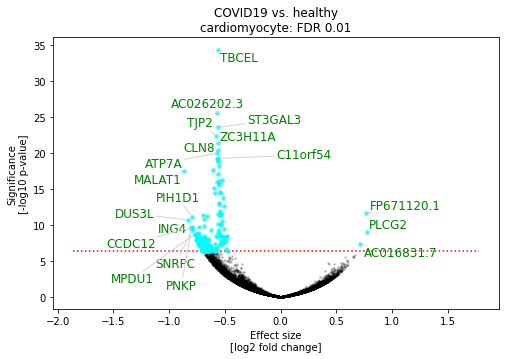

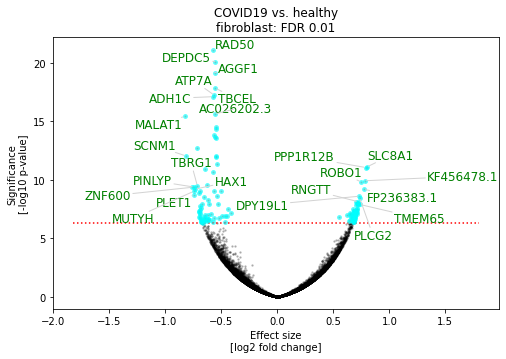

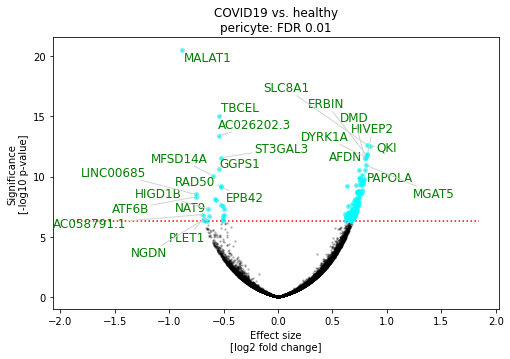

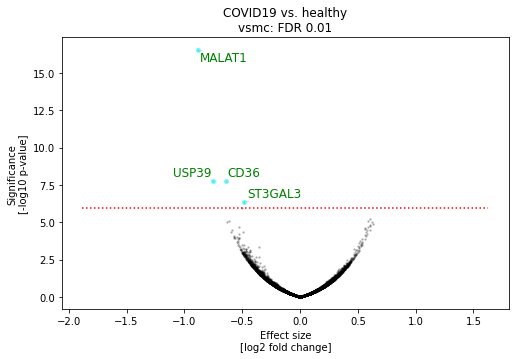

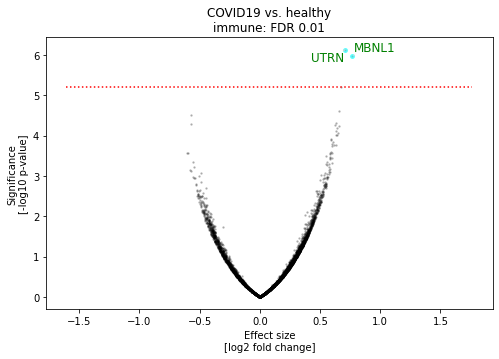

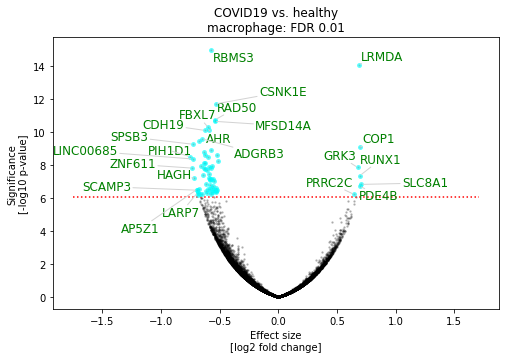

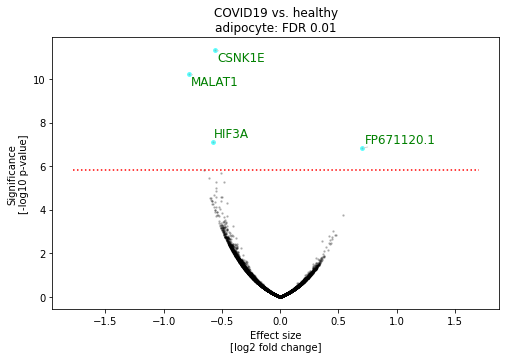

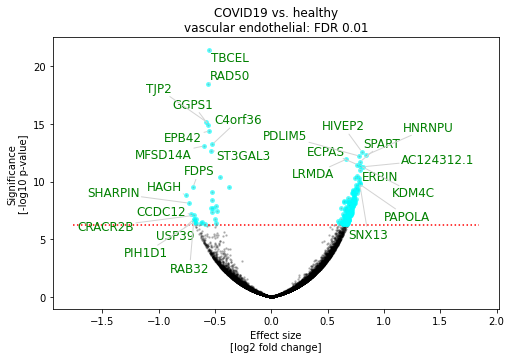

In [105]:
modifier = 'pseudobulk' if PSEUDOBULK else 'cell'

for k in df['cluster'].unique():
    
    try:
        volcano_plot(df_graham, 
                     FDR=0.01, 
                     cluster_column_label='cluster',
                     cluster_value=k,
                     test_group_value='COVID19',
                     comparison_value='healthy',
                     num=8,
                     title=f'COVID19 vs. healthy\n{k}: FDR 0.01',
                     show=False
                     )
        plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/graham_{modifier}_heart_{k}_volcano.pdf')
        plt.show()
    except AssertionError:
        pass

In [68]:
df = df[['gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob']]

In [107]:
df_graham['graham_pseudobulk_log2fc'] = df_graham['COVID19_log2fc']
df_graham['graham_pseudobulk_pval'] = df_graham['COVID19_pval']
df_graham['graham_pseudobulk_adjusted_pval'] = df_graham['adjusted']

In [108]:
df_combo = pd.merge(left=df, right=df_graham[['gene', 
                                              'cluster', 
                                              'graham_pseudobulk_log2fc', 
                                              'graham_pseudobulk_pval',
                                              'graham_pseudobulk_adjusted_pval']],
                    how='left', on=['gene', 'cluster'])

In [109]:
df_graham['cluster'].unique()

array(['vsmc', 'immune', 'fibroblast', 'macrophage', 'pericyte',
       'lymphatic endothelial', 'cardiomyocyte', 'adipocyte',
       'vascular endothelial'], dtype=object)

In [110]:
df_combo

Unnamed: 0      gene               cluster test.group comparison  \
0               0     PLCG2         cardiomyocyte    COVID19    healthy   
1               1      CTSL         cardiomyocyte    COVID19    healthy   
2               2    EXOSC8         cardiomyocyte    COVID19    healthy   
3               3   NDUFAF4         cardiomyocyte    COVID19    healthy   
4               4  TMEM179B         cardiomyocyte    COVID19    healthy   
...           ...       ...                   ...        ...        ...   
88004       88004     TTYH2  vascular endothelial    COVID19    healthy   
88005       88005     SRP19  vascular endothelial    COVID19    healthy   
88006       88006    MRPS15  vascular endothelial    COVID19    healthy   
88007       88007     SNX19  vascular endothelial    COVID19    healthy   
88008       88008   PPP4R3B  vascular endothelial    COVID19    healthy   

          logFC   AveExpr          t       P.Value     adj.P.Val          B  \
0      5.152630  4.065135  13.879645  4.445325e-15  8.754178e-11  24.298142   
1     -6.140759  2.184375 -11.436916  7.860921e-13  7.380219e-09  18.452254   
2     -2.692548  2.781197 -11.227102  1.242073e-12  7.380219e-09  18.670050   
3     -3.130870  3.277407 -11.145156  1.499054e-12  7.380219e-09  18.440547   
4     -2.875175  2.468725 -10.786201  3.450477e-12  1.321181e-08  17.583422   
...         ...       ...        ...           ...           ...        ...   
88004 -0.001088  2.326908  -0.001389  9.988991e-01  9.992406e-01  -6.091598   
88005  0.000188  3.817882   0.000470  9.996273e-01  9.998490e-01  -6.540551   
88006  0.000215  2.335612   0.000319  9.997473e-01  9.998490e-01  -6.109346   
88007 -0.000082  5.341663  -0.000298  9.997636e-01  9.998490e-01  -6.700246   
88008 -0.000018  6.117662  -0.000084  9.999338e-01  9.999338e-01  -6.847392   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
0                         1.502756                     0.029076   
1                         0.013148                     0.134068   
2                         0.027172                     0.130112   
3                         0.040429                     0.179886   
4                         0.022132                     0.107417   
...                            ...                          ...   
88004                     0.008939                     0.010138   
88005                     0.048410                     0.023689   
88006                     0.006269                     0.010448   
88007                     0.092872                     0.061860   
88008                     0.191201                     0.104892   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
0                    0.575764                0.026406                0.324532   
1                    0.011395                0.118170                0.001643   
2                    0.025529                0.114774                0.001534   
3                    0.036485                0.151450                0.003177   
4                    0.020708                0.096939                0.001424   
...                       ...                     ...                     ...   
88004                0.008475                0.009724                0.000464   
88005                0.043418                0.021930                0.003715   
88006                0.006269                0.010241                0.000000   
88007                0.079986                0.057722                0.010216   
88008                0.152426                0.093411                0.028442   

       comparison.frac.expr>1  bkg.prob  PPV.expr>0  PPV.expr>1  \
0                    0.001319  0.191386    0.388479    0.417893   
1                    0.013813  0.062684    0.607905    0.560708   
2                    0.013516  0.029085    0.699042    0.828584   
3                    0.023489  0.016481    0.830738    0.932852   
4                    0.009412  0.041773    0

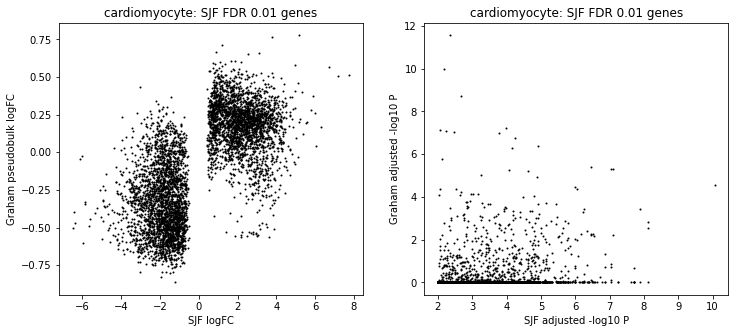

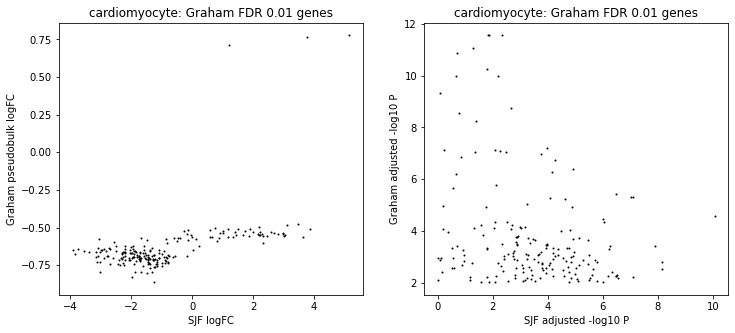

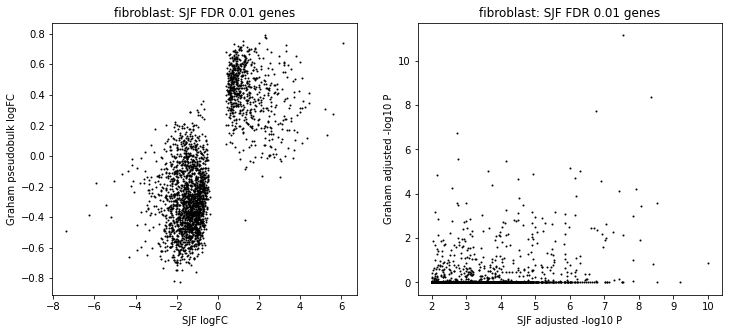

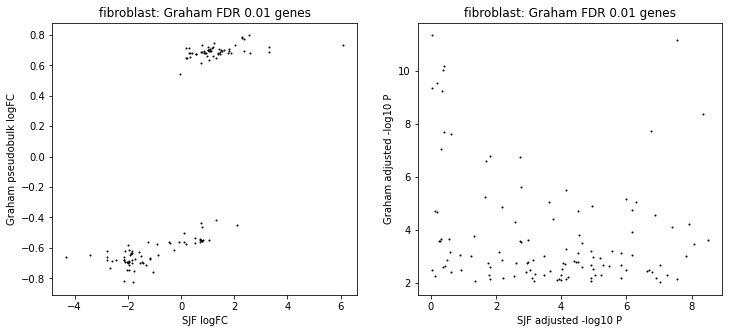

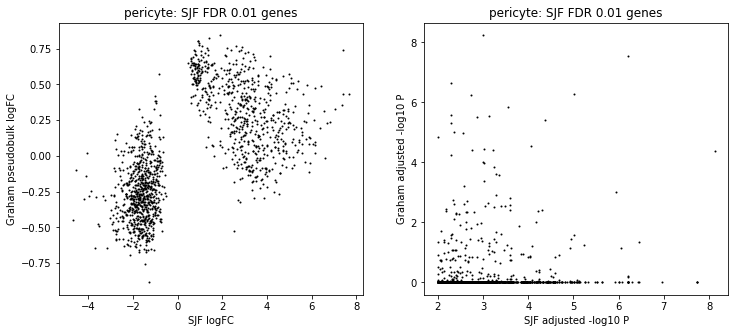

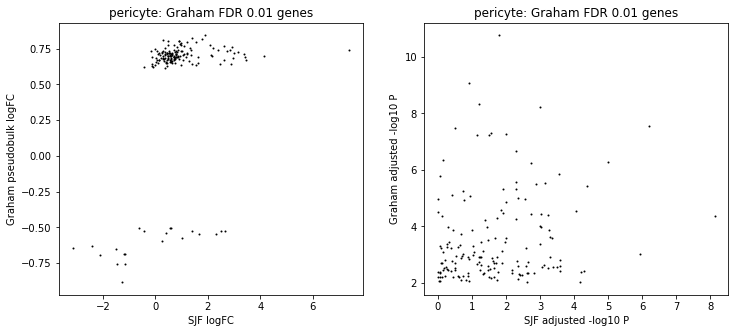

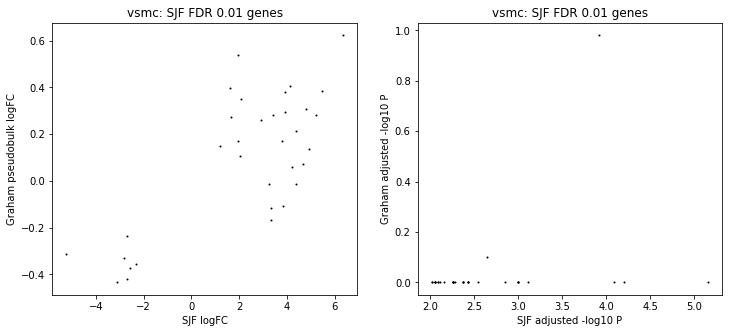

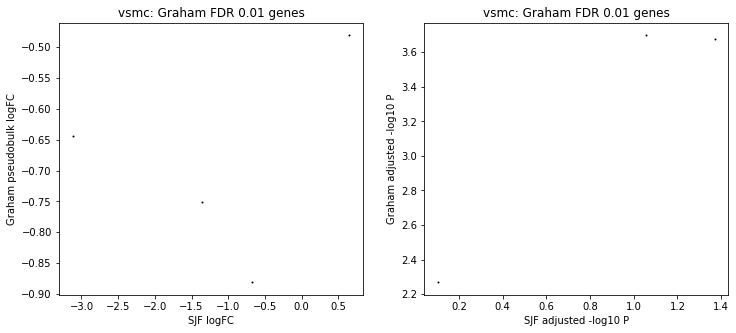

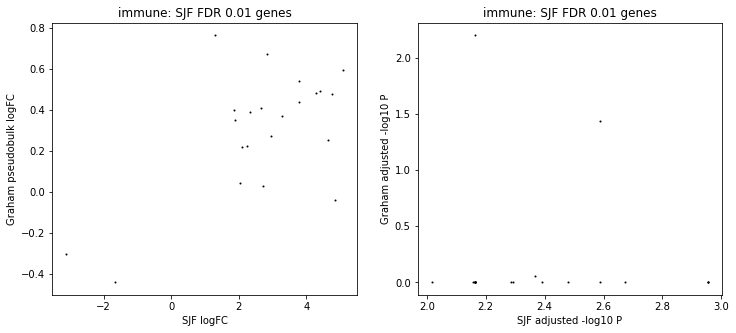

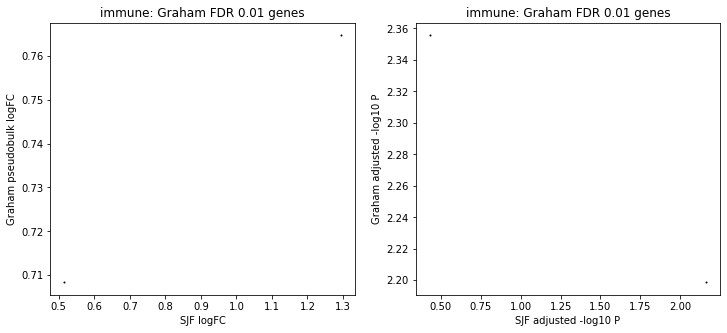

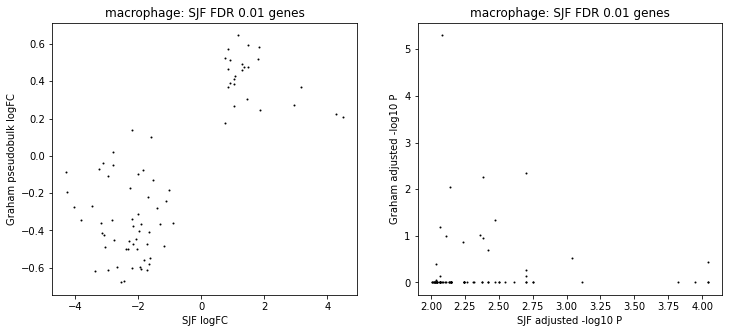

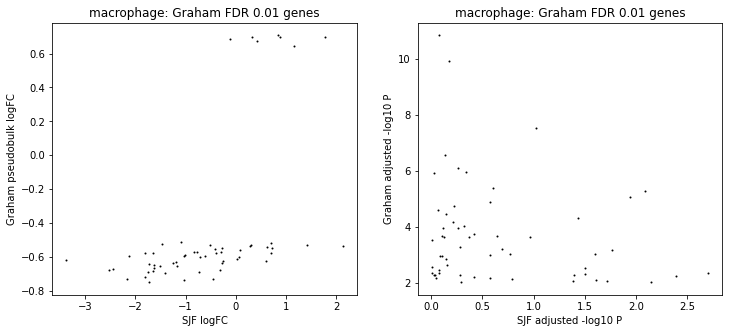

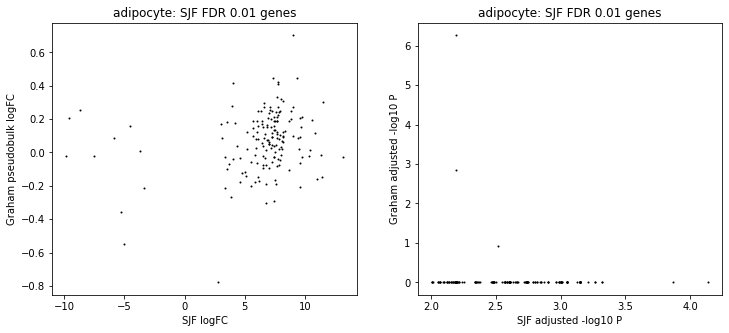

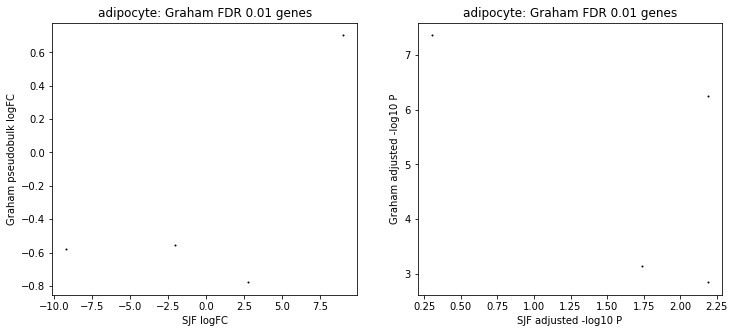

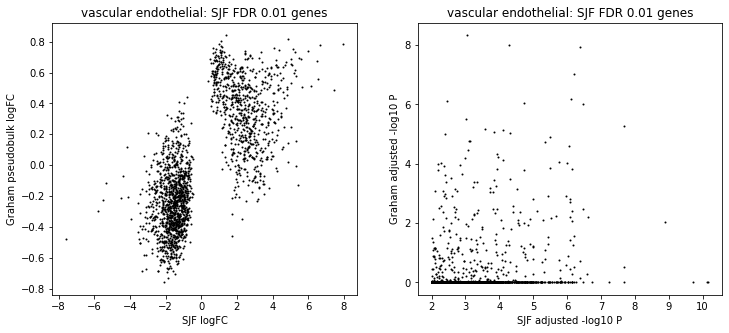

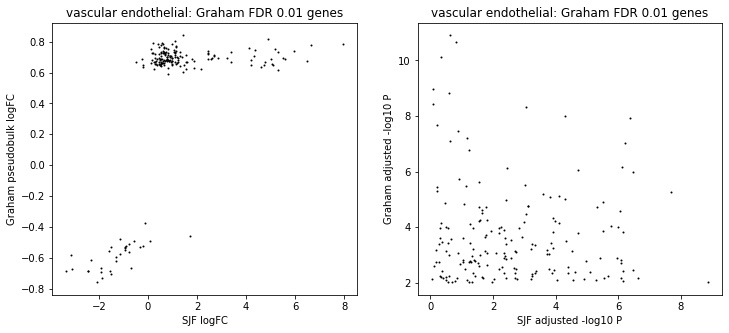

In [115]:
logFC = 'graham_pseudobulk_log2fc' if PSEUDOBULK else 'disease_log2fc'


for k in df_combo['cluster'].unique():
    
    df_tmp = df_combo[(df_combo['cluster'] == k)
                      & (df_combo['adj.P.Val'] <= 0.01)]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_tmp['logFC'],
             df_tmp[logFC], '.k', ms=2)
    plt.xlabel('SJF logFC')
    plt.ylabel(f'Graham {"pseudobulk" if PSEUDOBULK else "cell"} logFC')
    plt.title(f'{k}: SJF FDR 0.01 genes')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_tmp['adj.P.Val'].apply(lambda x: -np.log10(x)),
             df_tmp['graham_pseudobulk_adjusted_pval'].apply(lambda x: -np.log10(x)), '.k', ms=2)
    plt.xlabel('SJF adjusted -log10 P')
    plt.ylabel('Graham adjusted -log10 P')
    plt.title(f'{k}: SJF FDR 0.01 genes')
    plt.show()
    
    df_tmp = df_combo[(df_combo['cluster'] == k)
                      & (df_combo['graham_pseudobulk_adjusted_pval'] <= 0.01)]
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(df_tmp['logFC'],
             df_tmp[logFC], '.k', ms=2)
    plt.xlabel('SJF logFC')
    plt.ylabel(f'Graham {"pseudobulk" if PSEUDOBULK else "cell"} logFC')
    plt.title(f'{k}: Graham FDR 0.01 genes')
    
    plt.subplot(1, 2, 2)
    plt.plot(df_tmp['adj.P.Val'].apply(lambda x: -np.log10(x)),
             df_tmp['graham_pseudobulk_adjusted_pval'].apply(lambda x: -np.log10(x)), '.k', ms=2)
    plt.xlabel('SJF adjusted -log10 P')
    plt.ylabel('Graham adjusted -log10 P')
    plt.title(f'{k}: Graham FDR 0.01 genes')
    
    plt.show()

In [117]:
df_combo.columns

Index(['Unnamed: 0', 'gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob',
       'PPV.expr>0', 'PPV.expr>1', 'frac.cells.in.group.expr>0',
       'frac.cells.out.group.expr>0', 'frac.cells.in.group.expr>1',
       'frac.cells.out.group.expr>1', 'graham_pseudobulk_log2fc',
       'graham_pseudobulk_pval', 'graham_pseudobulk_adjusted_pval'],
      dtype='object')

In [123]:
df_combo = df_combo[['gene', 'cluster', 'test.group', 'comparison', 'logFC',
       'AveExpr', 't', 'P.Value', 'adj.P.Val', 'B',
       'test.group.cell.mean.counts', 'comparison.cell.mean.counts',
       'test.group.frac.expr>0', 'comparison.frac.expr>0',
       'test.group.frac.expr>1', 'comparison.frac.expr>1', 'bkg.prob',
       'PPV.expr>0', 'PPV.expr>1', 'frac.cells.in.group.expr>0',
       'frac.cells.out.group.expr>0', 'frac.cells.in.group.expr>1',
       'frac.cells.out.group.expr>1', 'graham_pseudobulk_log2fc',
       'graham_pseudobulk_pval', 'graham_pseudobulk_adjusted_pval']]
df_combo.to_csv('/home/jupyter-user/analysis/meta/DE/heart_DE_20210208_extraQC_with_graham_results.csv', 
        index=False)

### Overlap

Take Graham's significant genes and prioritize them based on my tests.

In [124]:
df_combo

gene               cluster test.group comparison     logFC  \
0         PLCG2         cardiomyocyte    COVID19    healthy  5.152630   
1          CTSL         cardiomyocyte    COVID19    healthy -6.140759   
2        EXOSC8         cardiomyocyte    COVID19    healthy -2.692548   
3       NDUFAF4         cardiomyocyte    COVID19    healthy -3.130870   
4      TMEM179B         cardiomyocyte    COVID19    healthy -2.875175   
...         ...                   ...        ...        ...       ...   
88004     TTYH2  vascular endothelial    COVID19    healthy -0.001088   
88005     SRP19  vascular endothelial    COVID19    healthy  0.000188   
88006    MRPS15  vascular endothelial    COVID19    healthy  0.000215   
88007     SNX19  vascular endothelial    COVID19    healthy -0.000082   
88008   PPP4R3B  vascular endothelial    COVID19    healthy -0.000018   

        AveExpr          t       P.Value     adj.P.Val          B  \
0      4.065135  13.879645  4.445325e-15  8.754178e-11  24.298142   
1      2.184375 -11.436916  7.860921e-13  7.380219e-09  18.452254   
2      2.781197 -11.227102  1.242073e-12  7.380219e-09  18.670050   
3      3.277407 -11.145156  1.499054e-12  7.380219e-09  18.440547   
4      2.468725 -10.786201  3.450477e-12  1.321181e-08  17.583422   
...         ...        ...           ...           ...        ...   
88004  2.326908  -0.001389  9.988991e-01  9.992406e-01  -6.091598   
88005  3.817882   0.000470  9.996273e-01  9.998490e-01  -6.540551   
88006  2.335612   0.000319  9.997473e-01  9.998490e-01  -6.109346   
88007  5.341663  -0.000298  9.997636e-01  9.998490e-01  -6.700246   
88008  6.117662  -0.000084  9.999338e-01  9.999338e-01  -6.847392   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
0                         1.502756                     0.029076   
1                         0.013148                     0.134068   
2                         0.027172                     0.130112   
3                         0.040429                     0.179886   
4                         0.022132                     0.107417   
...                            ...                          ...   
88004                     0.008939                     0.010138   
88005                     0.048410                     0.023689   
88006                     0.006269                     0.010448   
88007                     0.092872                     0.061860   
88008                     0.191201                     0.104892   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
0                    0.575764                0.026406                0.324532   
1                    0.011395                0.118170                0.001643   
2                    0.025529                0.114774                0.001534   
3                    0.036485                0.151450                0.003177   
4                    0.020708                0.096939                0.001424   
...                       ...                     ...                     ...   
88004                0.008475                0.009724                0.000464   
88005                0.043418                0.021930                0.003715   
88006                0.006269                0.010241                0.000000   
88007                0.079986                0.057722                0.010216   
88008                0.152426                0.093411                0.028442   

       comparison.frac.expr>1  bkg.prob  PPV.expr>0  PPV.expr>1  \
0                    0.001319  0.191386    0.388479    0.417893   
1                    0.013813  0.062684    0.607905    0.560708   
2                    0.013516  0.029085    0.699042    0.828584   
3                    0.023489  0.016481    0.830738    0.932852   
4                    0.009412  0.041773    0.602303    0.701800   
...                       ...       ...         ...         ...   
88004                0.000310  0.073010    0.148432    0.0

In [130]:
df_combo[df_combo['gene'] == 'ADAMTS4']

gene               cluster test.group comparison     logFC  \
2138   ADAMTS4         cardiomyocyte    COVID19    healthy  4.467378   
32418  ADAMTS4            fibroblast    COVID19    healthy -0.272678   
34565  ADAMTS4              pericyte    COVID19    healthy  1.727741   
46878  ADAMTS4                  vsmc    COVID19    healthy  4.229089   
75151  ADAMTS4             adipocyte    COVID19    healthy  0.469164   
81541  ADAMTS4  vascular endothelial    COVID19    healthy  2.383020   

        AveExpr         t   P.Value  adj.P.Val         B  \
2138  -1.889184  4.397655  0.000114   0.001045  1.213735   
32418  3.859542 -0.342036  0.734328   0.830575 -6.552847   
34565  6.109094  4.806261  0.000032   0.000779  1.798716   
46878  5.921506  2.472660  0.032692   0.267021 -3.686688   
75151  2.937737  0.285065  0.778970   0.904084 -5.556786   
81541  3.079803  1.771549  0.085131   0.190196 -4.701178   

       test.group.cell.mean.counts  comparison.cell.mean.counts  \
2138                      0.006903                     0.002374   
32418                     0.033062                     0.060098   
34565                     0.497771                     0.136436   
46878                     3.597807                     0.068993   
75151                     0.067416                     0.064361   
81541                     0.042257                     0.012931   

       test.group.frac.expr>0  comparison.frac.expr>0  test.group.frac.expr>1  \
2138                 0.004492                0.002044                0.001205   
32418                0.023711                0.039960                0.004898   
34565                0.264163                0.110473                0.104710   
46878                0.424132                0.047581                0.285192   
75151                0.056180                0.052834                0.011236   
81541                0.031809                0.011586                0.006965   

       comparison.frac.expr>1  bkg.prob  PPV.expr>0  PPV.expr>1  \
2138                 0.000231  0.084329    0.039201    0.024249   
32418                0.008825  0.042745    0.527467    0.490933   
34565                0.018701  0.009574    0.894722    0.885407   
46878                0.015860  0.009890    0.839351    0.933522   
75151                0.008646  0.036673    0.625111    0.532732   
81541                0.001138  0.056688    0.383848    0.314345   

       frac.cells.in.group.expr>0  frac.cells.out.group.expr>0  \
2138                     0.002364                     0.057933   
32418                    0.035264                     0.031581   
34565                    0.132839                     0.015621   
46878                    0.161504                     0.030901   
75151                    0.053097                     0.031833   
81541                    0.021115                     0.033883   

       frac.cells.in.group.expr>1  frac.cells.out.group.expr>1  \
2138                     0.000358                     0.014403   
32418                    0.007690                     0.007964   
34565                    0.031218                     0.004030   
46878                    0.097345                     0.006922   
75151                    0.008850                     0.007752   
81541                    0.003884                     0.008461   

       graham_pseudobulk_log2fc  graham_pseudobulk_pval  \
2138                  -0.039525                0.798033   
32418                 -0.198849                0.203425   
34565                  0.338440                0.028860   
46878                  0.509426                0.000819   
75151                  0.049101                0.753647   
81541                  0.096567                0.541009   

       graham_pseudobulk_adjusted_pval  
2138                          1.000000  
32418                         1.000000  
34565                         1.000000  
46878                         0.999936  
75151                         1

In [126]:
from IPython.display import display, HTML


gene_list = []

for k in df_combo['cluster'].unique():
    
    df_tmp = (df_combo[(df_combo['cluster'] == k)
                       & (df_combo['graham_pseudobulk_adjusted_pval'] <= 0.05)
                       & (df_combo['adj.P.Val'] <= 0.01)
                       & (df_combo['logFC'] > 1)
                       & (df_combo[logFC] > 0.5)
                       & (df_combo['bkg.prob'] < 0.5)
                       & (df_combo['test.group.cell.mean.counts'] > 0.05)]
              .sort_values(by='logFC', ascending=False))
    
    display(HTML(df_tmp.head().to_html()))
    
    gene_list.extend(df_tmp['gene'].values.tolist())
    
gene_list = np.unique(gene_list)

In [127]:
gene_list

array(['AC016831.7', 'AC092069.1', 'AC124312.1', 'AC245060.5', 'ADGRL2',
       'ADGRL4', 'AIG1', 'AKAP11', 'ASCC3', 'ASPH', 'ATP11C', 'ATP2C1',
       'BZW2', 'C1GALT1', 'CAMK2D', 'CBLB', 'CCDC50', 'CEMIP2', 'CHSY3',
       'COL12A1', 'COL6A3', 'CRIM1', 'CTIF', 'DAP', 'DAZAP1', 'ETS1',
       'FAM120A', 'FAM20C', 'FARP1', 'FAT4', 'FBN1', 'FP236383.1',
       'FP671120.1', 'G3BP1', 'GAB1', 'GJA1', 'GLS', 'GNG12', 'GRB10',
       'GRK3', 'HIVEP2', 'HNRNPU', 'IQCJ-SCHIP1', 'IRF2BP2', 'IVNS1ABP',
       'KITLG', 'LDLRAD3', 'LEMD3', 'LNPK', 'MAN2A1', 'MAPRE2', 'MBNL1',
       'MEF2C-AS1', 'MGAT5', 'MID2', 'MLLT3', 'MTFR1', 'MTPN', 'NAB1',
       'NAP1L1', 'NBEA', 'NDRG1', 'NDUFA10', 'NDUFAF2', 'NEK7', 'NHLRC2',
       'NHS', 'NPTN', 'NT5DC1', 'PAG1', 'PCAT19', 'PCNX1', 'PCNX2',
       'PHLDB2', 'PLCG2', 'PLCL2', 'PLOD2', 'POLA1', 'PPP2R2A', 'PREX2',
       'PRKN', 'PRRC2C', 'QKI', 'RNF217', 'RNGTT', 'ROBO1', 'SIPA1L2',
       'SLC16A7', 'SLC25A36', 'SLCO3A1', 'SLFN11', 'SPRED1', 'ST7',
   

In [128]:
print(', '.join(gene_list))

AC016831.7, AC092069.1, AC124312.1, AC245060.5, ADGRL2, ADGRL4, AIG1, AKAP11, ASCC3, ASPH, ATP11C, ATP2C1, BZW2, C1GALT1, CAMK2D, CBLB, CCDC50, CEMIP2, CHSY3, COL12A1, COL6A3, CRIM1, CTIF, DAP, DAZAP1, ETS1, FAM120A, FAM20C, FARP1, FAT4, FBN1, FP236383.1, FP671120.1, G3BP1, GAB1, GJA1, GLS, GNG12, GRB10, GRK3, HIVEP2, HNRNPU, IQCJ-SCHIP1, IRF2BP2, IVNS1ABP, KITLG, LDLRAD3, LEMD3, LNPK, MAN2A1, MAPRE2, MBNL1, MEF2C-AS1, MGAT5, MID2, MLLT3, MTFR1, MTPN, NAB1, NAP1L1, NBEA, NDRG1, NDUFA10, NDUFAF2, NEK7, NHLRC2, NHS, NPTN, NT5DC1, PAG1, PCAT19, PCNX1, PCNX2, PHLDB2, PLCG2, PLCL2, PLOD2, POLA1, PPP2R2A, PREX2, PRKN, PRRC2C, QKI, RNF217, RNGTT, ROBO1, SIPA1L2, SLC16A7, SLC25A36, SLCO3A1, SLFN11, SPRED1, ST7, STAMBPL1, TCF4, TES, THBS2, TIMP2, TMEM164, TMEM30A, TRIM9, TRPS1, TSC22D2, TSHZ1, VEGFC, XPO1, ZNF407, ZNF521, ZNF638, ZNF91


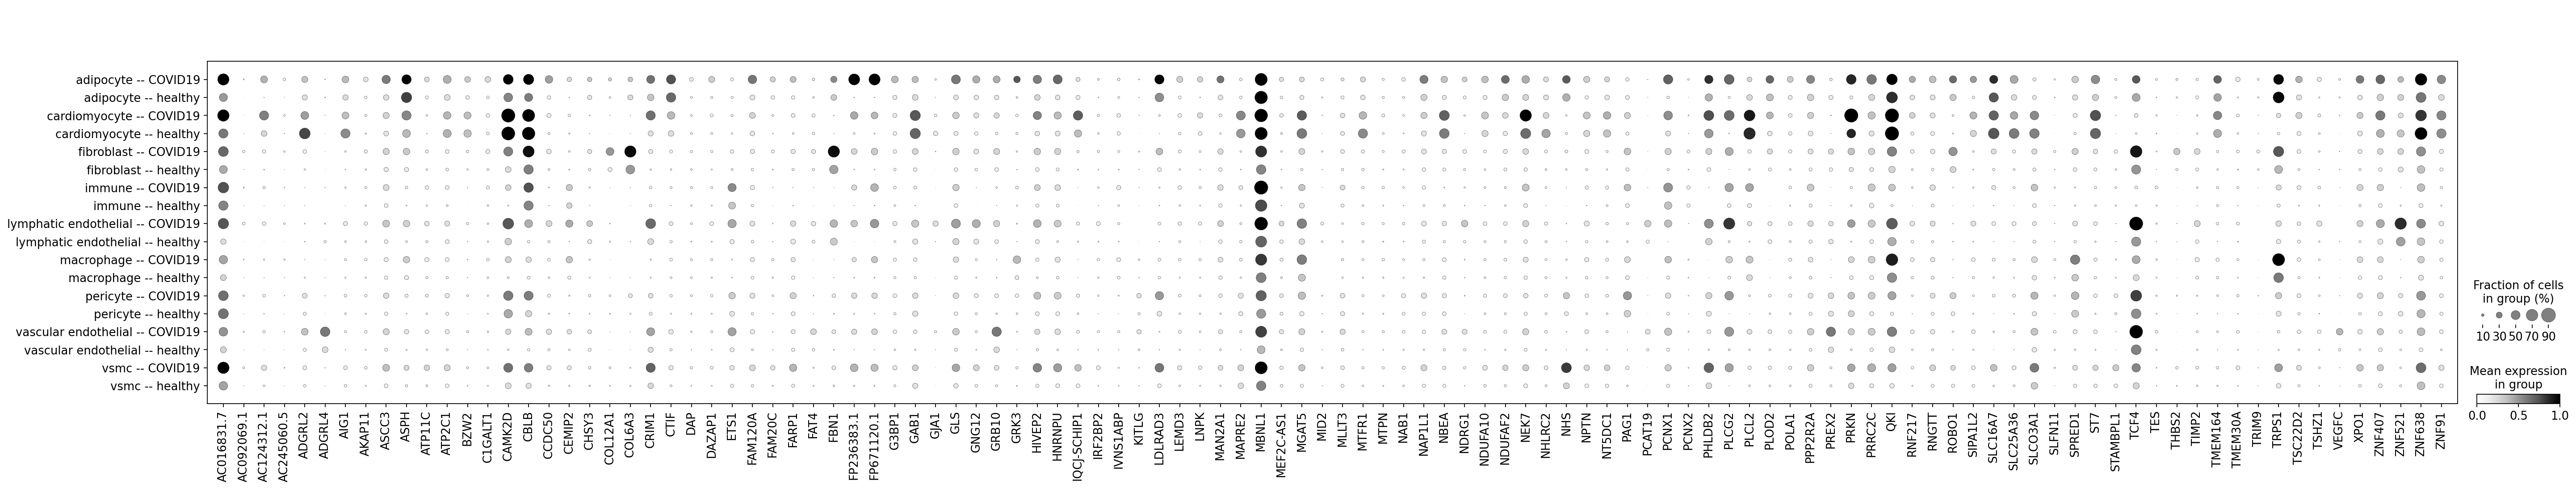

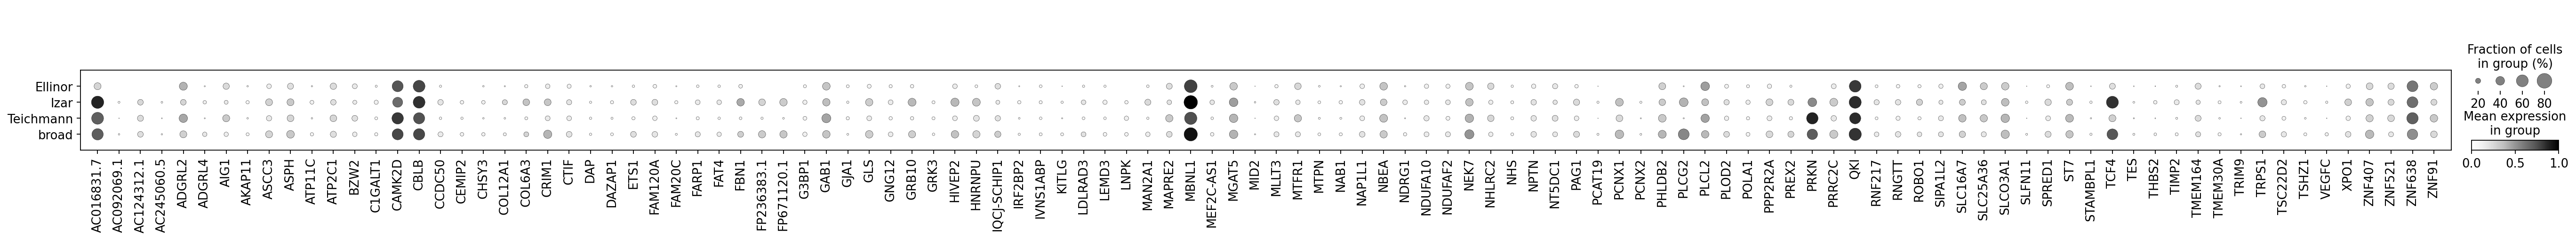

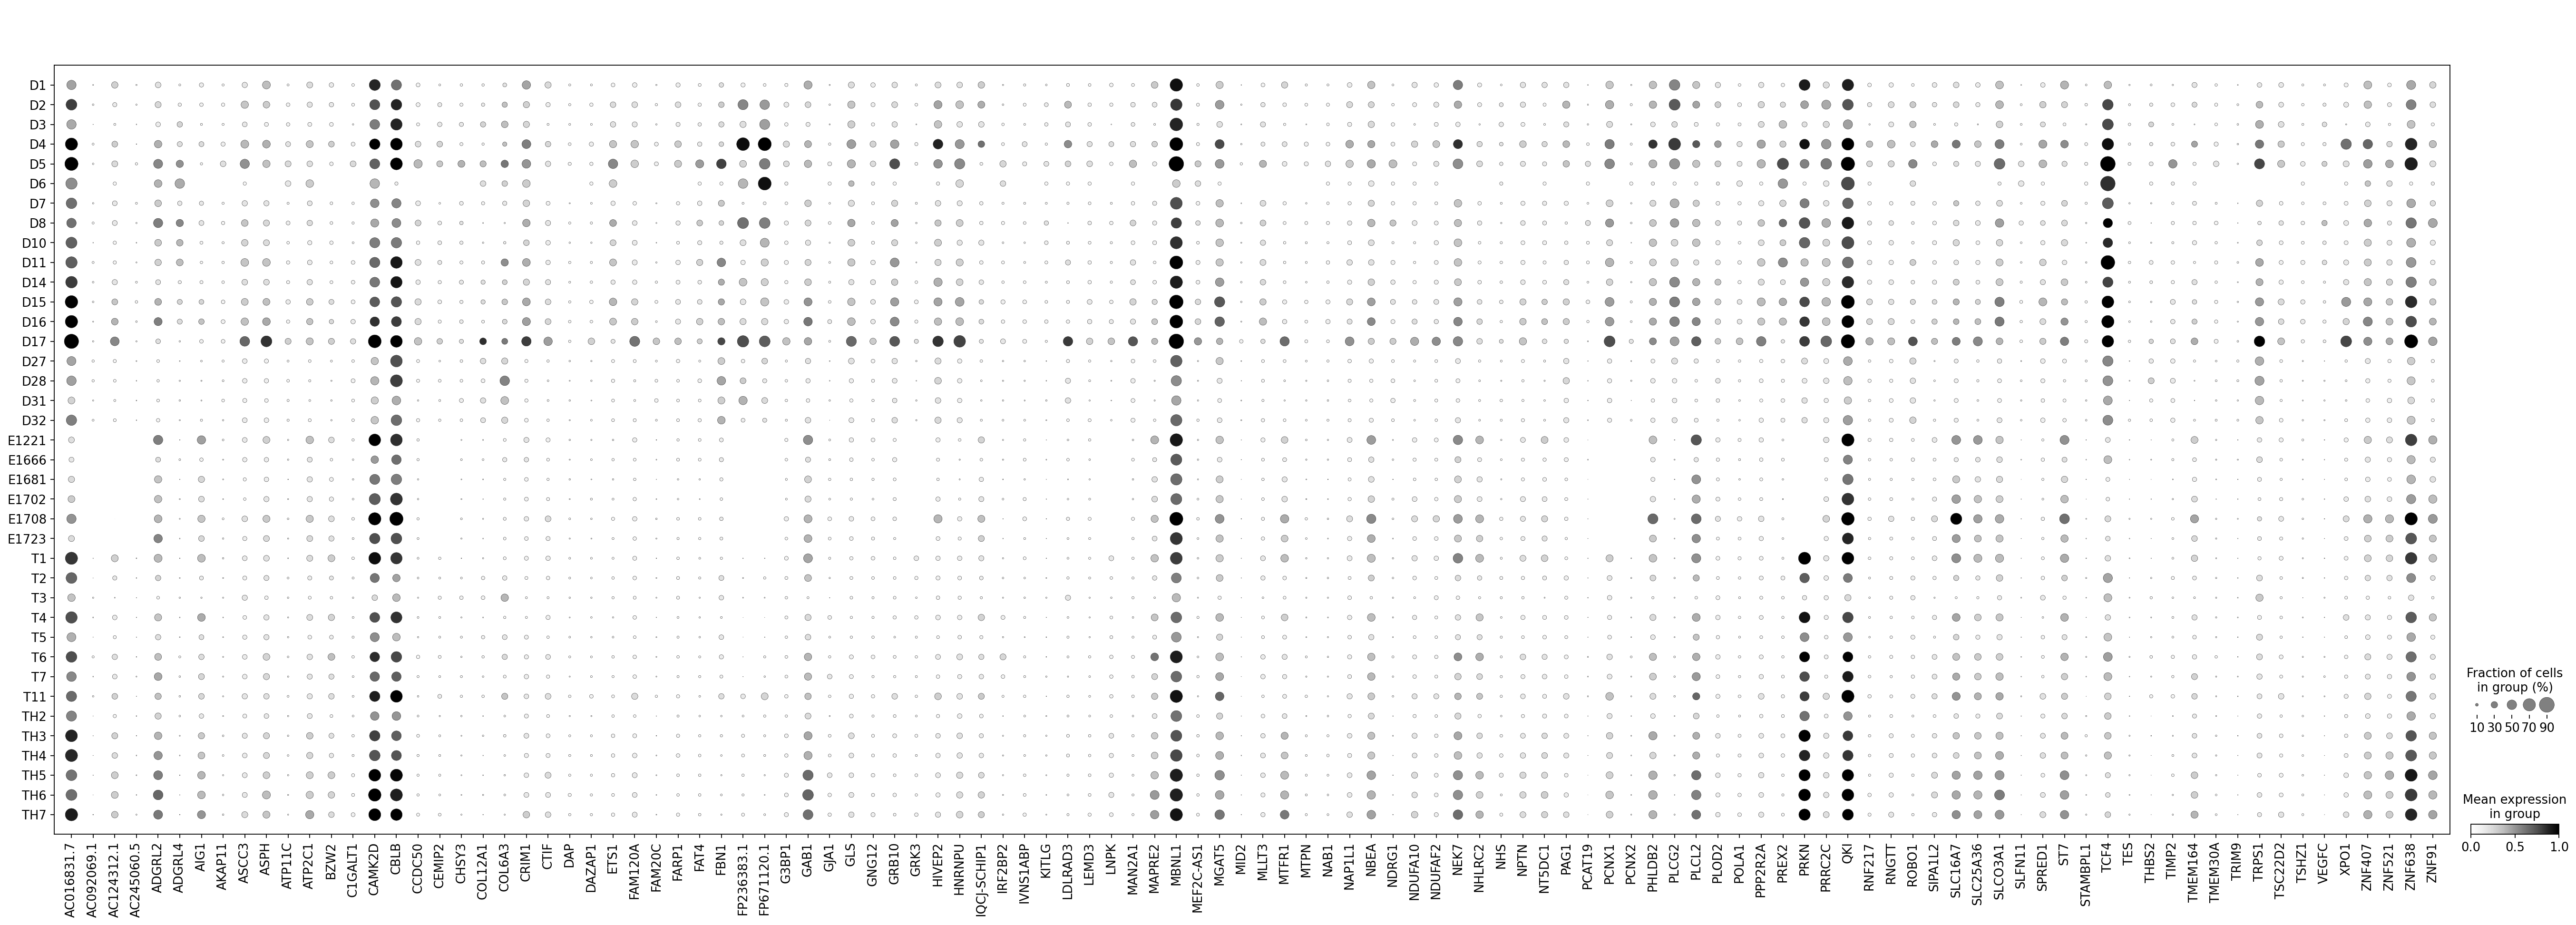

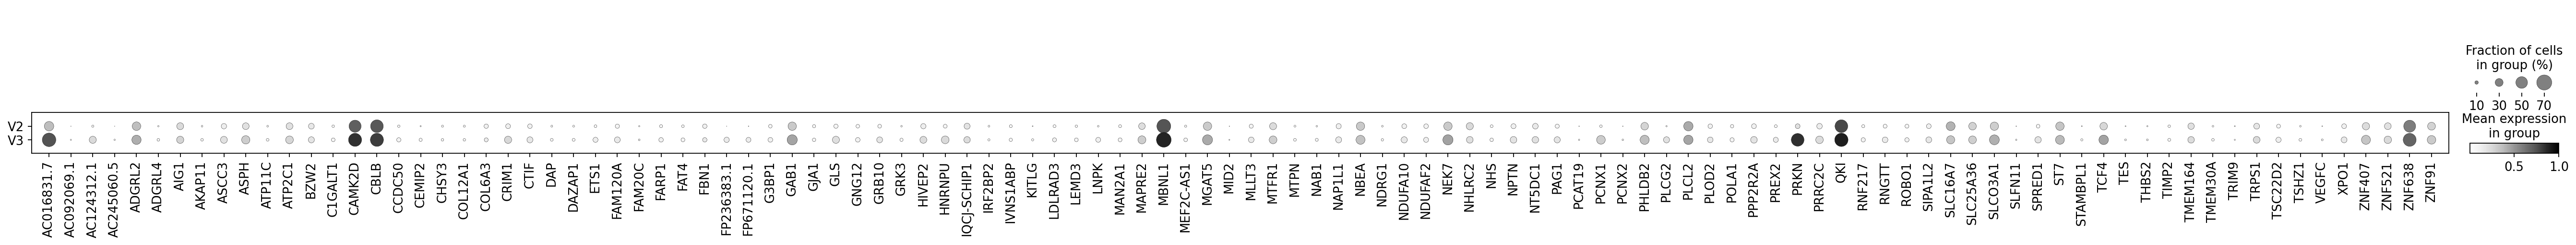

In [129]:
sc.set_figure_params(fontsize=14)

for group in ['cluster_disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=gene_list,
#                   standard_scale='var',
                  log=True,
                  color_map='Greys',
#                   swap_axes=True,
                  vmax=1,
                  smallest_dot=15)

In [238]:
remarkable_gene_list = [
#     'AC008440.2', 'AC092069.1',  # total unknowns
    'AFDN',  # cell-cell junctions
    'DDX60L',  # antiviral
    'FBN1',  # ECM
    'FP236383.1', 'FP671120.1',  # total unknowns
    'GRB10',  # growth factor receptor binder
    'HIVEP2',  # antiviral
    'HNRNPU',  # negative regulation of HIV
    'LDLRAD3',  # LDL receptor
    'MGAT5',  # regulation of inflammation
    'PCNX1',  # ... development?
    'PHLDB2',  # neuronal signalling?
    'PLCG2',  # auto-inflammation
    'PLCL2',  # related to PLCG2
    'QKI',  # represses translation
    'SYNM',  # muscle
    'TSHZ2',  # transcriptional repressor
]

## (Equivalent of Extended Data Figure 11d... but with extra cell QC)

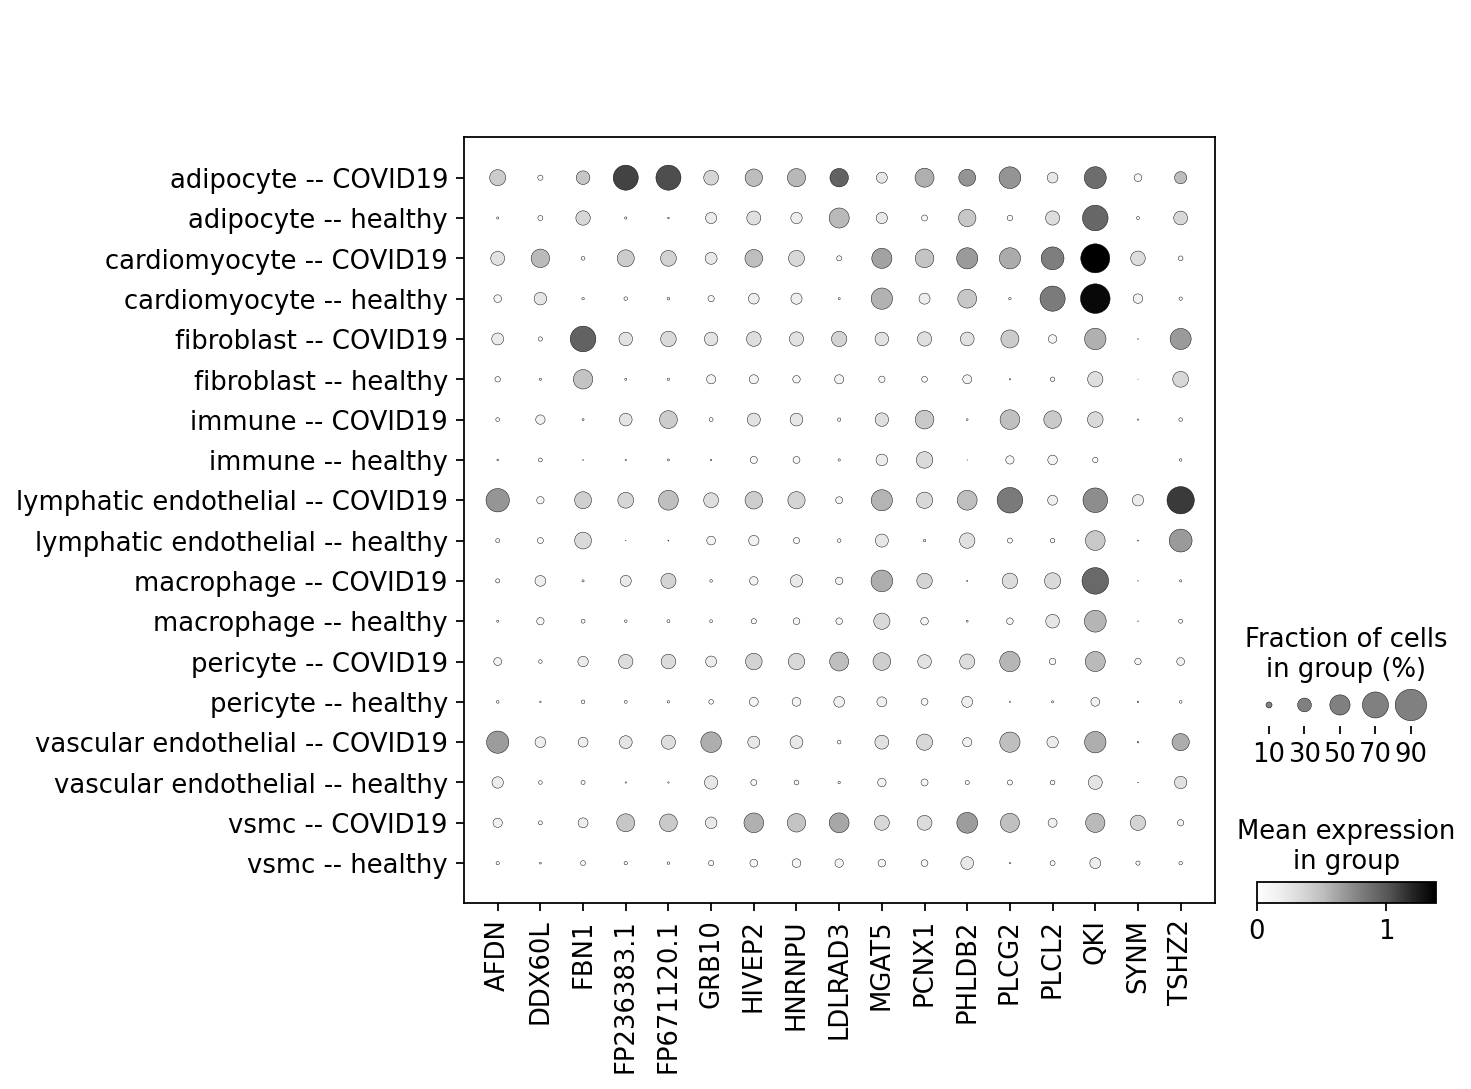

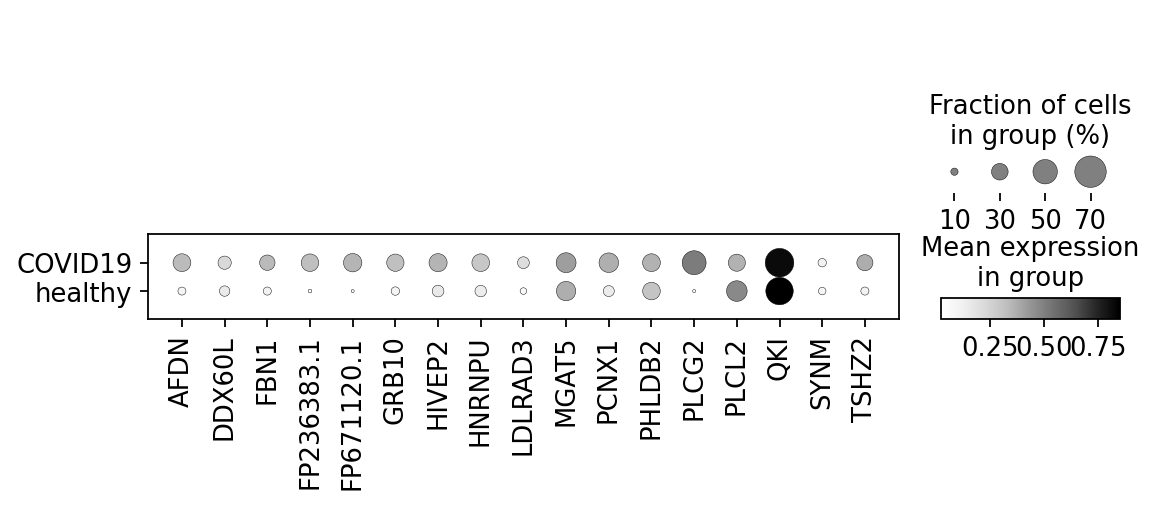

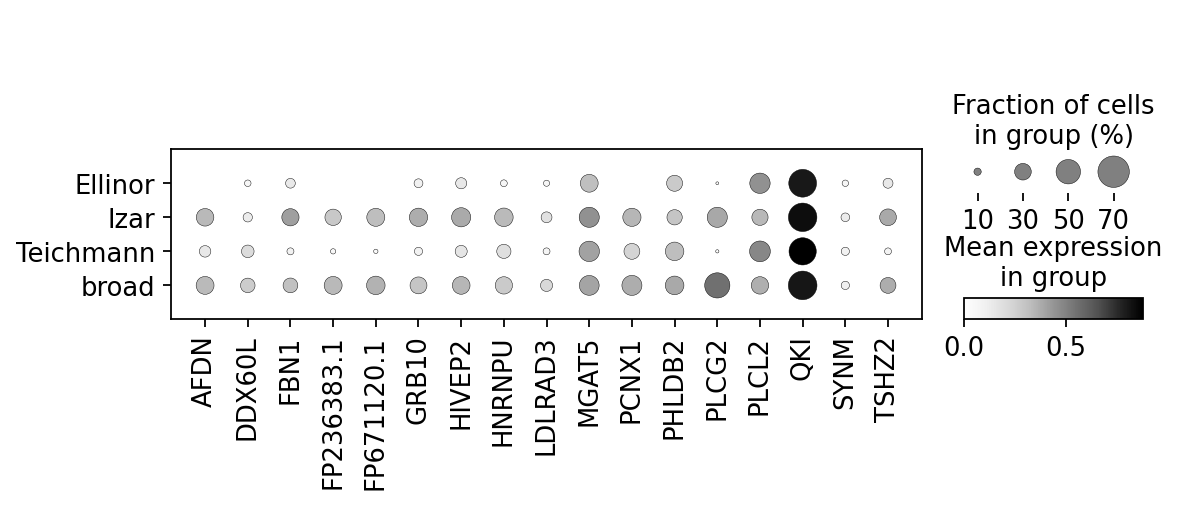

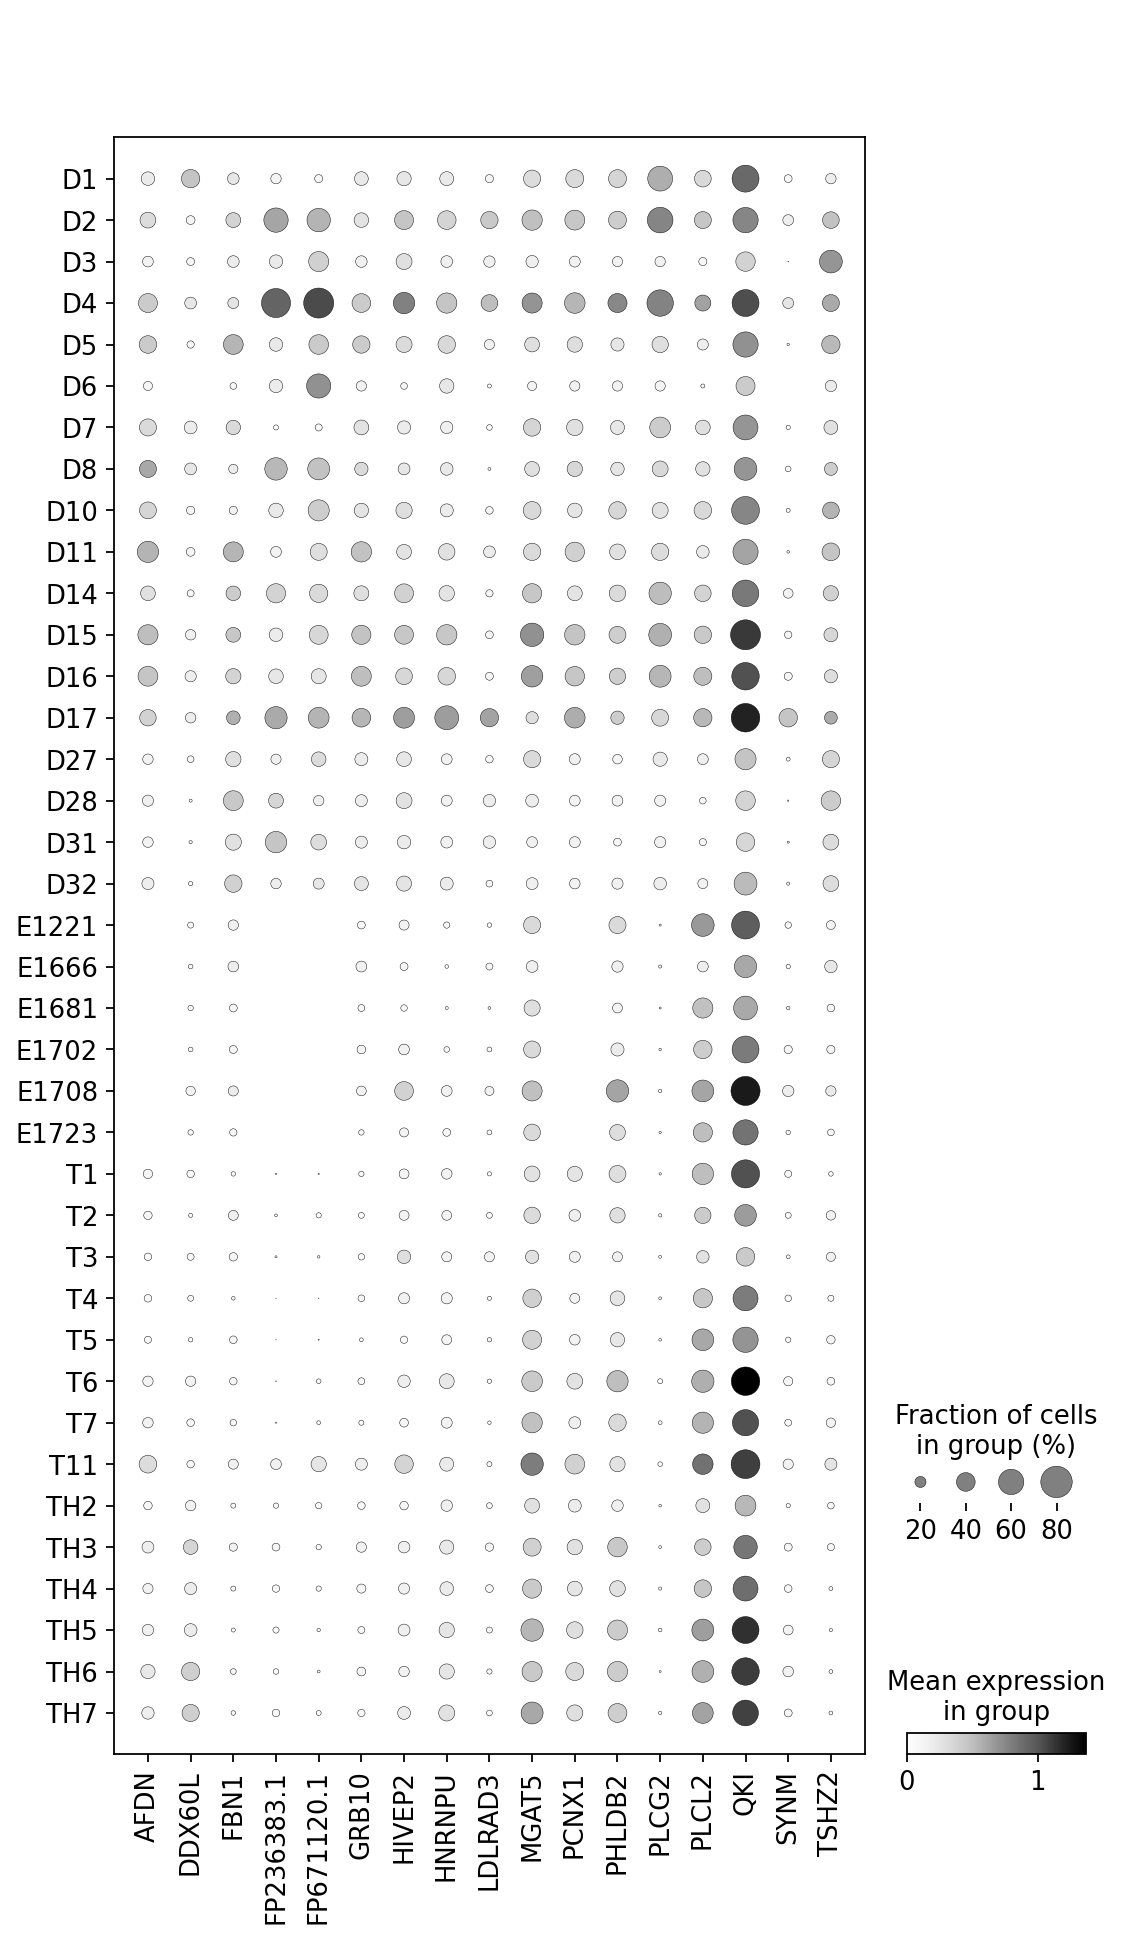

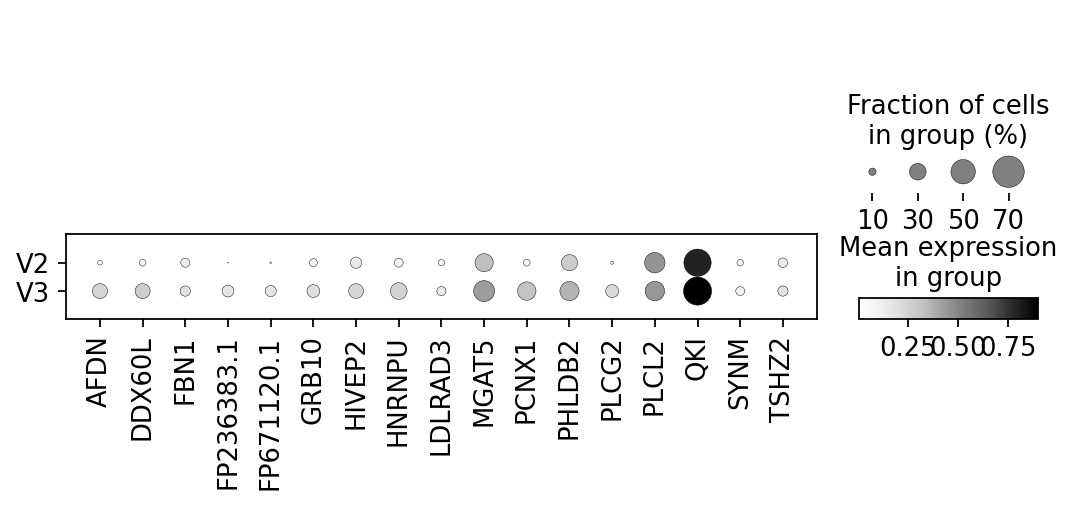

In [239]:
for group in ['cluster_disease', 'disease', 'study', 'individual', 'version10x']:

    sc.pl.dotplot(adata,
                  groupby=group,
                  var_names=remarkable_gene_list,
#                   standard_scale='var',
                  log=True,
                  color_map='Greys',
#                   vmax=1,
                  smallest_dot=25,
                  show=False)
    plt.gcf().savefig(f'/home/jupyter-user/analysis/meta/DE/heart_{group}_dotplot.pdf',
                      bbox_inches='tight')